In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import datetime

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [3]:
#pip install catboost

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
RANDOM_SEED = 42

In [6]:
VAL_SIZE   = 0.20   # 20%

In [7]:
train = pd.read_csv('parsing_finall.csv', header = None)


In [8]:
test = pd.read_csv('test.csv')

Предобработаем спарсенный датасет, чтобы привести его к виду тестового:

In [9]:
train.rename(columns = {
    0:'brand',1:'productionDate',2:'bodyType',3:'color',4:'engineDisplacement',
        5:'enginePower',6:'fuelType',7:'vehicleTransmission',
        8:'Привод',9:'Руль',10:'Владение',11:'Состояние',12:'Таможня',13:'price',14:'mileage',
          15:'Владельцы',16:'car_url'
},inplace=True)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219111 entries, 0 to 219110
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   brand                219111 non-null  object 
 1   productionDate       219111 non-null  int64  
 2   bodyType             219111 non-null  object 
 3   color                219111 non-null  object 
 4   engineDisplacement   219111 non-null  object 
 5   enginePower          219111 non-null  object 
 6   fuelType             219111 non-null  object 
 7   vehicleTransmission  219111 non-null  object 
 8   Привод               219111 non-null  object 
 9   Руль                 219111 non-null  object 
 10  Владение             36994 non-null   object 
 11  Состояние            219111 non-null  object 
 12  Таможня              219111 non-null  object 
 13  price                214065 non-null  float64
 14  mileage              219111 non-null  int64  
 15  Владельцы        

In [11]:
train.head()

,brand,productionDate,bodyType,color,engineDisplacement,enginePower,fuelType,vehicleTransmission,Привод,Руль,Владение,Состояние,Таможня,price,mileage,Владельцы,car_url
0,0,1,2,3,4,5,6,7,8,9,10,11,12,13.0,14,15,16
1,bmw,2013,седан,чёрный,2.0 л,184,Бензин,автоматическая,задний,Левый,7 лет и 2 месяца,Не требует ремонта,Растаможен,1430000.0,148000,2,https://auto.ru/cars/used/sale/bmw/5er/1103394...
2,bmw,2013,седан,коричневый,1.6 л,136,Бензин,автоматическая,задний,Левый,NaN,Не требует ремонта,Растаможен,1089000.0,122233,3,https://auto.ru/cars/used/sale/bmw/3er/1103608...
3,bmw,2013,седан,чёрный,2.0 л,245,Бензин,автоматическая,полный,Левый,NaN,Не требует ремонта,Растаможен,1295000.0,129871,3,https://auto.ru/cars/used/sale/bmw/5er/1102632...
4,bmw,2018,седан,серый,4.4 л,600,Бензин,автоматическая,полный,Левый,NaN,Не требует ремонта,Растаможен,6999000.0,41066,3,https://auto.ru/cars/used/sale/bmw/m5/11031568...


In [12]:
train['price'].isna().sum()

5046

В данных извлеченных с помощью парсинга 5046 строк, где нет цены автомобиля, это
объявления, которые еще висят на сайте, но автомобиль уже продан, и цена скрыта.
Удалим эти строки так как цена это наша целевая переменная и они нам бесполезны

In [13]:
train[train['price'].isna()]

,brand,productionDate,bodyType,color,engineDisplacement,enginePower,fuelType,vehicleTransmission,Привод,Руль,Владение,Состояние,Таможня,price,mileage,Владельцы,car_url
22,bmw,2020,внедорожник 5 дв.,белый,3.0 л,249,Дизель,автоматическая,полный,Левый,5 месяцев,Не требует ремонта,Растаможен,NaN,3500,1,https://auto.ru/cars/used/sale/bmw/x6/11032689...
57,volkswagen,2017,внедорожник 5 дв.,белый,3.0 л,204,Дизель,автоматическая,полный,Левый,NaN,Не требует ремонта,Растаможен,NaN,105000,1,https://auto.ru/cars/used/sale/volkswagen/toua...
90,nissan,2016,внедорожник 5 дв.,чёрный,3.5 л,249,Бензин,вариатор,полный,Левый,4 года и 4 месяца,Не требует ремонта,Растаможен,NaN,71000,1,https://auto.ru/cars/used/sale/nissan/murano/1...
121,mercedes,2019,внедорожник 5 дв.,белый,4.0 л,585,Бензин,автоматическая,полный,Левый,1 год и 11 месяцев,Не требует ремонта,Растаможен,NaN,16388,2,https://auto.ru/cars/used/sale/mercedes/g_klas...
158,toyota,2019,внедорожник 5 дв.,серый,2.8 л,177,Дизель,автоматическая,полный,Левый,1 год и 8 месяцев,Не требует ремонта,Растаможен,NaN,39000,2,https://auto.ru/cars/used/sale/toyota/land_cru...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218955,bmw,2020,внедорожник 5 дв.,белый,3.0 л,340,Бензин,автоматическая,полный,Левый,10 месяцев,Не требует ремонта,Растаможен,NaN,3917,1,https://auto.ru/cars/used/sale/bmw/x7/11029786...
218996,volkswagen,2019,внедорожник 5 дв.,серебристый,2.0 л,180,Бензин,роботизированная,полный,Левый,NaN,Не требует ремонта,Растаможен,NaN,31000,1,https://auto.ru/cars/used/sale/volkswagen/tigu...
219039,nissan,2020,внедорожник 5 дв.,чёрный,2.0 л,144,Бензин,вариатор,полный,Левый,6 месяцев,Не требует ремонта,Растаможен,NaN,21600,1,https://auto.ru/cars/used/sale/nissan/x_trail/...
219078,mercedes,2019,внедорожник 5 дв.,чёрный,2.0 л,245,Дизель,автоматическая,полный,Левый,NaN,Не требует ремонта,Растаможен,NaN,49000,1,https://auto.ru/cars/used/sale/mercedes/gle_kl...


Итак, получилось спарсить 17 колонок. Рассмотрим более подробно 

Получим еще один признак из 'car_url' извлечем информацию для 'model_name'

In [14]:
train = train.iloc[1:]

In [15]:
train['model_name'] = train['car_url'].apply(lambda x: x.split('/')[7])

In [16]:
# Удалим строки с пустыми значениями 'price', так как это наша целевая переменная
train = train.dropna(axis='index', how='any', subset=['price'])

In [17]:
train['model_name'].value_counts()[0:30]

octavia         7060
cr_v            6627
outlander       5040
rx              4312
qx80            3898
civic           3621
xc60            3579
x_trail         3233
touareg         3228
camry           3166
tiguan          3022
lx              2986
kodiaq          2939
land_cruiser    2738
lancer          2724
highlander      2698
xc90            2631
pajero_sport    2606
s60             2372
es              2346
q50             2284
accord          2243
5er             2162
3er             2112
q5              2109
q7              2094
nx              2081
x5              2064
pathfinder      2037
superb          2019
Name: model_name, dtype: int64

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214064 entries, 1 to 219110
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   brand                214064 non-null  object 
 1   productionDate       214064 non-null  int64  
 2   bodyType             214064 non-null  object 
 3   color                214064 non-null  object 
 4   engineDisplacement   214064 non-null  object 
 5   enginePower          214064 non-null  object 
 6   fuelType             214064 non-null  object 
 7   vehicleTransmission  214064 non-null  object 
 8   Привод               214064 non-null  object 
 9   Руль                 214064 non-null  object 
 10  Владение             33896 non-null   object 
 11  Состояние            214064 non-null  object 
 12  Таможня              214064 non-null  object 
 13  price                214064 non-null  float64
 14  mileage              214064 non-null  int64  
 15  Владельцы        

Дубликаты объявлений:

In [19]:
train = train.drop_duplicates()
#train.drop_duplicates(subset=['car_url'], keep='first', inplace=True, ignore_index=True)

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30390 entries, 1 to 219075
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   brand                30390 non-null  object 
 1   productionDate       30390 non-null  int64  
 2   bodyType             30390 non-null  object 
 3   color                30390 non-null  object 
 4   engineDisplacement   30390 non-null  object 
 5   enginePower          30390 non-null  object 
 6   fuelType             30390 non-null  object 
 7   vehicleTransmission  30390 non-null  object 
 8   Привод               30390 non-null  object 
 9   Руль                 30390 non-null  object 
 10  Владение             10202 non-null  object 
 11  Состояние            30390 non-null  object 
 12  Таможня              30390 non-null  object 
 13  price                30390 non-null  float64
 14  mileage              30390 non-null  int64  
 15  Владельцы            30390 non-null

In [21]:
test.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,1603226284,RUB,2014,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603226288,RUB,2012,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [22]:
test['model_name'].value_counts()[:30]

OCTAVIA               1418
5ER                   1026
LANCER                 855
E_KLASSE               809
PASSAT                 782
A6                     757
3ER                    752
POLO                   724
CAMRY                  709
X5                     675
X_TRAIL                654
A4                     626
QASHQAI                609
S_KLASSE               549
OUTLANDER              544
LAND_CRUISER           514
ALMERA                 502
TIGUAN                 491
TOUAREG                469
COROLLA                456
RAV_4                  447
C_KLASSE               428
GOLF                   424
LAND_CRUISER_PRADO     387
TEANA                  374
RAPID                  370
7ER                    343
M_KLASSE               343
XC90                   340
JETTA                  324
Name: model_name, dtype: int64

In [23]:
test['model_name'][:30].values

array(['OCTAVIA', 'OCTAVIA', 'SUPERB', 'OCTAVIA', 'OCTAVIA', 'OCTAVIA_RS',
       'YETI', 'OCTAVIA', 'KODIAQ', 'YETI', 'RAPID', 'OCTAVIA', 'SUPERB',
       'KODIAQ', 'OCTAVIA', 'KODIAQ', 'OCTAVIA', 'KODIAQ', 'RAPID',
       'RAPID', 'KODIAQ', 'KODIAQ', 'RAPID', 'OCTAVIA', 'SUPERB', 'YETI',
       'SUPERB', 'OCTAVIA', 'OCTAVIA', 'FABIA'], dtype=object)

In [24]:
test.head().T

,0,1,2,3,4
bodyType,лифтбек,лифтбек,лифтбек,лифтбек,лифтбек
brand,SKODA,SKODA,SKODA,SKODA,SKODA
car_url,https://auto.ru/cars/used/sale/skoda/octavia/1...,https://auto.ru/cars/used/sale/skoda/octavia/1...,https://auto.ru/cars/used/sale/skoda/superb/11...,https://auto.ru/cars/used/sale/skoda/octavia/1...,https://auto.ru/cars/used/sale/skoda/octavia/1...
color,синий,чёрный,серый,коричневый,белый
complectation_dict,NaN,NaN,"{""id"":""20026336"",""name"":""Ambition"",""available_...","{""id"":""20803582"",""name"":""Ambition"",""available_...",NaN
description,"Все автомобили, представленные в продаже, прох...",ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,"Все автомобили, представленные в продаже, прох...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...
engineDisplacement,1.2 LTR,1.6 LTR,1.8 LTR,1.6 LTR,1.8 LTR
enginePower,105 N12,110 N12,152 N12,110 N12,152 N12
equipment_dict,"{""engine-proof"":true,""tinted-glass"":true,""airb...","{""cruise-control"":true,""asr"":true,""esp"":true,""...","{""cruise-control"":true,""tinted-glass"":true,""es...","{""cruise-control"":true,""roller-blind-for-rear-...","{""cruise-control"":true,""asr"":true,""esp"":true,""..."
fuelType,бензин,бензин,бензин,бензин,бензин


In [25]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

В тестовом датасете 32 признака.
Всего 6 числовых признаков: 'mileage','modelDate', 'numberOfDoors','parsing_unixtime','productionDate','sell_id'.

Пропуски есть в :'complectation_dic't(28268),'equipment_dict'(9996),'Владени'е(22691) - очень большое количество, поэтому эти признаки нам для дальнейшего анализа не пригодятся
'super_gen' - Пока оставим в качестве резервного источника информации. Поименение в модели без обработки невозможно.
'vehicleConfiguration' - повторяет информацию других столбцов

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

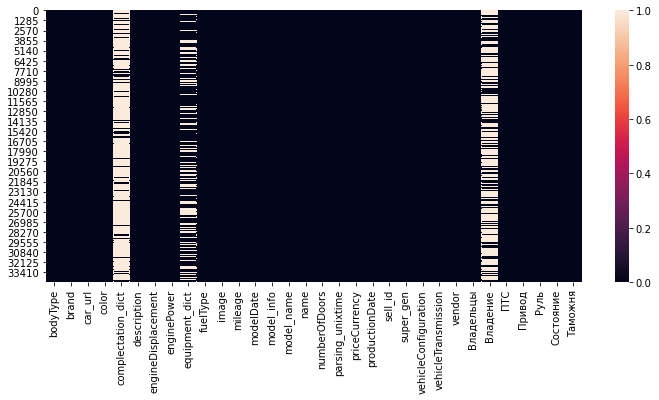

In [26]:
f, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(test.isnull(), cbar=True)
test.isnull().sum()

###  Предобработка:

Признаки: car_url,description,complectation_dict,equipment_dict,image,model_info,super_gen предлагаю пока отложить.
Они содержат информацию, повторяющуюся в других столбцах, либо это url объявления либо url фотографии авто. К тому же они плохо заполнены.
Признак 'priceCurrency','Таможня','Состояние' все 34686 значений рубли ,не требует ремонта и растаможен, навряд-ли они нам помогут в анализе,
не будем их в дальнейшем использовать при построении модели.


In [27]:
test.priceCurrency.value_counts()

RUB    34686
Name: priceCurrency, dtype: int64

In [28]:
test.Состояние.value_counts()

Не требует ремонта    34686
Name: Состояние, dtype: int64

In [29]:
# Признак ПТС тоже пока придется отложить, так как его у меня нет в парсинге
test.ПТС.value_counts()

Оригинал    30098
Дубликат     4587
Name: ПТС, dtype: int64

In [30]:
#Признак carURL так-же отложим, хотя он есть и спарсеном датасете, в моделировании он не поможет

In [31]:
# Выделим из признака 'enginePower' мощность двигателя:
test['enginePower'] = test['enginePower'].apply(lambda x: x.replace(' N12', ''))

### Парсинг:

При помощи парсинга мне удалось собрать датасет из 17 признаков, 16 из которых соответсвуют данному нам датасету,
17-тый - это "price", наша целевая переменная.
По этим признакам будем объединять наши датасеты в дальнейшем.

In [32]:
train.columns

Index(['brand', 'productionDate', 'bodyType', 'color', 'engineDisplacement',
       'enginePower', 'fuelType', 'vehicleTransmission', 'Привод', 'Руль',
       'Владение', 'Состояние', 'Таможня', 'price', 'mileage', 'Владельцы',
       'car_url', 'model_name'],
      dtype='object')

In [33]:
# Почистим колонку enginePower в спарсенном датасете
train = train[~train.enginePower.str.contains('/')]

In [34]:
train.enginePower.value_counts()

 249    1947
 150    1741
 184     930
 110     926
 170     840
        ... 
 630       1
 104       1
 285       1
 242       1
 42        1
Name: enginePower, Length: 305, dtype: int64

In [35]:
# Приведем колонки 'brand',['fuelType'] в соответствие с тестовым датасетом
train['brand'] = train['brand'].str.upper()
train['fuelType'] = train['fuelType'].str.lower()
train['model_name'] = train['model_name'].str.upper()

In [36]:
test['Состояние'].value_counts()

Не требует ремонта    34686
Name: Состояние, dtype: int64

In [37]:
test['Таможня'].value_counts()

Растаможен    34686
Name: Таможня, dtype: int64

Признаки 'Таможня','Состояние' - Растаможен  и не требует ремонта(кроме нескольких неправильных значений попавших при парсинге) единственное значение для всех  - избавимся от них в последствии.


Переведем признак 'enginePower' в числовой формат:

In [38]:
test['enginePower'] = test['enginePower'].values.astype('int64')
train['enginePower'] = train['enginePower'].values.astype('int64')


# Рассмотрим признаки по отдельности:

 ### Признак 'brand'

In [39]:
test.brand.value_counts()

BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
MERCEDES      4180
TOYOTA        3913
AUDI          3421
MITSUBISHI    2843
SKODA         2741
VOLVO         1463
HONDA         1150
INFINITI       871
LEXUS          834
Name: brand, dtype: int64

In [40]:
train.brand.value_counts()

BMW           3754
TOYOTA        3739
MERCEDES      3735
VOLKSWAGEN    3706
NISSAN        3544
AUDI          2911
MITSUBISHI    2386
SKODA         2318
VOLVO         1287
HONDA         1078
LEXUS         1077
INFINITI       771
Name: brand, dtype: int64

In [41]:
# Избавимся от бренда "0" - ошибка парсинга
train = train[~train.brand.str.contains('0')]

In [42]:
train.groupby('brand').price.describe()

,count,mean,std,min,25%,50%,75%,max
brand,,,,,,,,
AUDI,2911.0,1.397942e+06,1.284947e+06,40000.0,550000.0,1085000.0,1791111.00,13979800.0
BMW,3754.0,2.237360e+06,1.844195e+06,60000.0,1099000.0,1699749.5,2914250.00,22200000.0
HONDA,1078.0,7.629525e+05,5.368196e+05,54000.0,400000.0,615000.0,1038750.00,7000000.0
INFINITI,771.0,1.721978e+06,9.687566e+05,105000.0,1080000.0,1509000.0,2100000.00,6210000.0
LEXUS,1077.0,2.662285e+06,1.603370e+06,115000.0,1570000.0,2297000.0,3390000.00,9800000.0
MERCEDES,3735.0,3.032075e+06,3.263716e+06,45000.0,1150000.0,2089000.0,3650000.00,27800000.0
MITSUBISHI,2386.0,7.545521e+05,6.272267e+05,20000.0,270125.0,522500.0,1090209.25,6000000.0
NISSAN,3544.0,7.833257e+05,5.519672e+05,35000.0,380000.0,684500.0,1045000.00,8590000.0
SKODA,2318.0,8.097491e+05,4.899881e+05,35000.0,490000.0,690000.0,979750.00,3299000.0


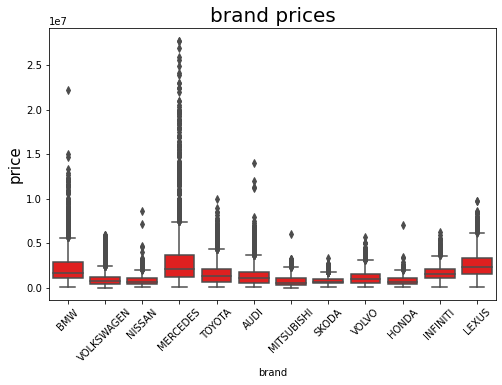

In [43]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='price', x='brand', 
                  data=train, color='red')
g1.set_title("brand prices", fontsize=20)

g1.set_ylabel("price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

Самые дорогие марки -это мерседес, бмв и лексус, самые дешевые -  шкода и ниссан

### Признак 'productionDate'

In [44]:
train.productionDate.value_counts()

2012    2365
2013    2328
2014    2240
2011    2000
2016    1949
        ... 
1957       1
1973       1
1963       1
1975       1
1949       1
Name: productionDate, Length: 68, dtype: int64

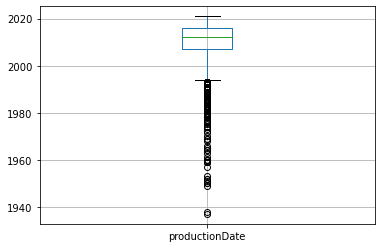

In [45]:
train.boxplot(column=['productionDate'])

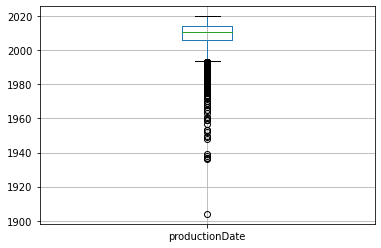

In [46]:
test.boxplot(column=['productionDate'])

In [47]:
test[test.productionDate < 1940]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
1777,хэтчбек 3 дв.,SKODA,https://auto.ru/cars/used/sale/skoda/popular/1...,чёрный,NaN,"Авто после длительного простоя, под восстановл...",1.1 LTR,30,NaN,бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,14000,1934,"{""code"":""POPULAR"",""name"":""Popular"",""ru_name"":""...",POPULAR,1.1 MT (30 л.с.),3,1603232963,RUB,1939,1097046168,"{""id"":""20783514"",""displacement"":1089,""engine_t...",HATCHBACK_3_DOORS MECHANICAL 1.1,механическая,EUROPEAN,3 или более,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
3174,седан,AUDI,https://auto.ru/cars/used/sale/audi/920/109152...,чёрный,NaN,"Ауди кабриолет, 1938 г., ретро, на ходу, есть ...",3.3 LTR,75,NaN,бензин,https://autoru.naydex.net/ys1kR7800/fbd964zfcB...,90000,1938,"{""code"":""920"",""name"":""920"",""ru_name"":""920"",""mo...",920,3.3 MT (75 л.с.),4,1603124719,RUB,1938,1091525266,"{""id"":""20652212"",""displacement"":3281,""engine_t...",SEDAN MECHANICAL 3.3,механическая,EUROPEAN,2 владельца,34 года и 2 месяца,Оригинал,задний,Левый,Не требует ремонта,Растаможен
9625,седан,BMW,https://auto.ru/cars/used/sale/bmw/326/1094373...,бежевый,NaN,Оригинальные запчасти. Своевременное обслужива...,2.0 LTR,51,NaN,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,16000,1936,"{""code"":""326"",""name"":""326"",""ru_name"":""326"",""mo...",326,2.0 MT (51 л.с.),4,1603115889,RUB,1937,1094373106,"{""id"":""20654826"",""displacement"":1971,""engine_t...",SEDAN MECHANICAL 2.0,механическая,EUROPEAN,2 владельца,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
9819,седан 2 дв.,BMW,https://auto.ru/cars/used/sale/bmw/321/1040149...,чёрный,NaN,"БМВ 321 1937 г., прекрасно восстановленная, вы...",2.0 LTR,46,"{""condition"":true,""abs"":true,""bluetooth"":true,...",бензин,https://autoru.naydex.net/lICN99c69/9bc7d3Rr7k...,4500,1937,"{""code"":""321"",""name"":""321"",""ru_name"":""321"",""mo...",321,2.0 MT (46 л.с.),2,1603116699,RUB,1937,1040149625,"{""id"":""20654694"",""displacement"":1971,""engine_t...",SEDAN_2_DOORS MECHANICAL 2.0,механическая,EUROPEAN,3 или более,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
16891,седан,MERCEDES,https://auto.ru/cars/used/sale/mercedes/w136/1...,красный,NaN,"Очень редкое авто, было произведено менее 100 ...",1.7 LTR,38,NaN,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,1,1936,"{""code"":""W136"",""name"":""W136"",""ru_name"":""в136"",...",W136,1.7 MT (38 л.с.),4,1603245646,RUB,1936,1099428966,"{""id"":""21180018"",""displacement"":1697,""engine_t...",SEDAN MECHANICAL 1.7,механическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
16944,кабриолет,MERCEDES,https://auto.ru/cars/used/sale/mercedes/simple...,белый,NaN,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3 LTR,32,NaN,бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,48000,1904,"{""code"":""SIMPLEX"",""name"":""Simplex"",""ru_name"":""...",SIMPLEX,5.3 MT (32 л.с.),0,1603245843,RUB,1904,1093802104,"{""id"":""21743990"",""displacement"":5322,""engine_t...",CABRIO MECHANICAL 5.3,механическая,EUROPEAN,1 владелец,6 лет и 8 месяцев,Оригинал,задний,Правый,Не требует ремонта,Растаможен


Большинство машин продаются с датой выпуска 2007-2015 год. Однако есть и редкие раритетные экземпляры, их нельзя считать выбросами. Оставим все значения.

Создадим еще один признак data['years_num'] - возраст машины: 2021-productionDate

In [48]:
test['years_num'] = 2021-test['productionDate']
train['years_num'] = 2021-train['productionDate']

In [49]:
train['years_num'].describe()

count    30306.000000
mean        10.433676
std          7.074294
min          0.000000
25%          5.000000
50%          9.000000
75%         14.000000
max         84.000000
Name: years_num, dtype: float64

In [50]:
test['years_num'].describe()

count    34686.000000
mean        11.735398
std          7.047661
min          1.000000
25%          7.000000
50%         10.000000
75%         15.000000
max        117.000000
Name: years_num, dtype: float64

Разобьем возраст на интервалы ['age_intervals']

In [51]:

bins = [-1, 3, 6, 10, 20, 35, 117]
numbers = ['3', '6','13','20','35', '117']

test['age_intervals']=pd.cut(test['years_num'],bins,labels=numbers)
train['age_intervals']=pd.cut(train['years_num'],bins,labels=numbers)

In [52]:
#train['years_num'] = 2021-train['productionDate']
#train['age_intervals']=pd.cut(train['years_num'],bins,labels=numbers)

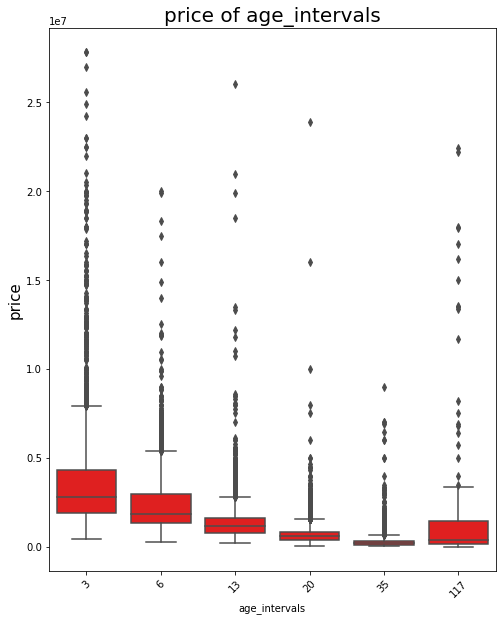

In [53]:
plt.figure(figsize=(8, 10))
g1 = sns.boxplot(y='price', x='age_intervals', 
                  data=train, color='red')
g1.set_title("price of age_intervals", fontsize=20)

g1.set_ylabel("price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

Самые дорогие по цене б/у машины - это трехлетки, или же раритетные тачки под 100 лет.
В районе 35 лет - самый автохлам.

### Признак 'bodyType'

In [54]:
train.bodyType.value_counts()

внедорожник 5 дв.          11854
седан                      10725
лифтбек                     1943
хэтчбек 5 дв.               1744
универсал 5 дв.             1026
минивэн                      763
купе                         757
компактвэн                   372
хэтчбек 3 дв.                355
пикап двойная кабина         245
купе-хардтоп                 137
фургон                       113
внедорожник 3 дв.             94
родстер                       81
кабриолет                     58
седан-хардтоп                 13
пикап полуторная кабина        7
микровэн                       5
лимузин                        4
седан 2 дв.                    4
пикап одинарная кабина         3
тарга                          1
внедорожник открытый           1
универсал 3 дв.                1
Name: bodyType, dtype: int64

In [55]:
test.bodyType.value_counts()

седан                      13147
внедорожник 5 дв.          12228
лифтбек                     2232
хэтчбек 5 дв.               2124
универсал 5 дв.             1276
минивэн                      995
купе                         824
компактвэн                   489
хэтчбек 3 дв.                485
пикап двойная кабина         280
купе-хардтоп                 158
внедорожник 3 дв.            115
родстер                       99
фургон                        97
кабриолет                     90
седан-хардтоп                 12
микровэн                       7
седан 2 дв.                    6
лимузин                        6
пикап полуторная кабина        5
пикап одинарная кабина         5
внедорожник открытый           3
тарга                          2
фастбек                        1
Name: bodyType, dtype: int64

In [56]:
# Построим график зависимости цены от кузова, выберем для этого самые часто встречающиеся кузова:
bodyType_max = train.bodyType.value_counts()[:12]
bodyType_max

внедорожник 5 дв.       11854
седан                   10725
лифтбек                  1943
хэтчбек 5 дв.            1744
универсал 5 дв.          1026
минивэн                   763
купе                      757
компактвэн                372
хэтчбек 3 дв.             355
пикап двойная кабина      245
купе-хардтоп              137
фургон                    113
Name: bodyType, dtype: int64

In [57]:
train['bodyType1'] = train.bodyType

In [58]:
train['bodyType_maximum'] = train['bodyType1'].apply(lambda x: x if x in bodyType_max else 'other')

In [59]:
train['log_price'] = np.log(train.price)

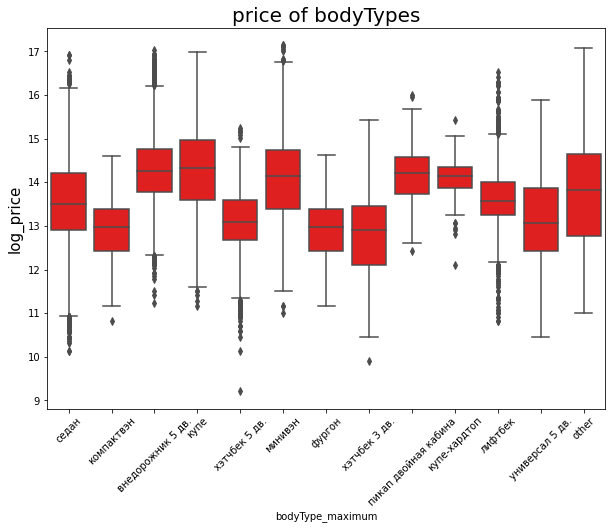

In [60]:
plt.figure(figsize=(10, 7))
g1 = sns.boxplot(y='log_price', x='bodyType_maximum', 
                  data=train, color='red')
g1.set_title("price of bodyTypes", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

Самые дорогие кузова это купе, минивэн и большой 5дв. внедорожник, самые дешевые - это фургон, компактвэн и хэтч.

### Признак 'color'

In [61]:
train.color.value_counts()

чёрный         9501
белый          6028
серый          3833
серебристый    2894
синий          2847
коричневый     1468
красный        1360
зелёный         709
бежевый         497
голубой         300
пурпурный       222
золотистый      186
жёлтый          174
фиолетовый      161
оранжевый       114
розовый          12
Name: color, dtype: int64

In [62]:
test.color.value_counts()

чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
зелёный          952
бежевый          639
голубой          457
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
розовый           13
Name: color, dtype: int64

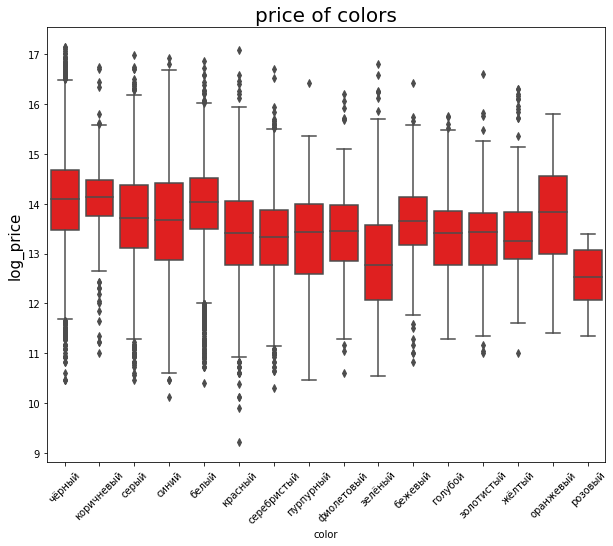

In [63]:
plt.figure(figsize=(10, 8))
g1 = sns.boxplot(y='log_price', x='color', 
                  data=train, color='red')
g1.set_title("price of colors", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

Самый 'дорогой' цвет-это черный, затем с небольшим отрывом - белый, синий, серый и коричневый. Да уж какие-то безрадостные популярные цвета авто.
Неожиданно оранжевый, но, видимо в выборке есть небольшое количество дорогих оранжевых спорткаров, медианное значение оранжевого не велико.
Самый 'дешевый цвет' - розовый. Видимо блондинка в розовом кабриолете - всего лишь миф.

### Признак 'engineDisplacement'

In [64]:
test.engineDisplacement.value_counts()

2.0 LTR    7391
1.6 LTR    4973
3.0 LTR    3915
1.8 LTR    3349
2.5 LTR    2477
2.4 LTR    1745
3.5 LTR    1710
1.4 LTR    1635
1.5 LTR     725
1.2 LTR     485
4.4 LTR     447
2.8 LTR     384
4.7 LTR     377
1.3 LTR     365
5.5 LTR     361
4.0 LTR     356
3.2 LTR     348
4.5 LTR     346
2.1 LTR     271
3.7 LTR     242
2.2 LTR     236
4.2 LTR     228
1.9 LTR     221
2.3 LTR     203
2.7 LTR     189
3.6 LTR     183
5.6 LTR     170
5.0 LTR     158
5.7 LTR     135
2.9 LTR     131
4.6 LTR     108
3.1 LTR      88
4.8 LTR      84
1.7 LTR      59
1.0 LTR      57
3.8 LTR      57
 LTR         55
2.6 LTR      55
0.7 LTR      53
6.0 LTR      53
3.3 LTR      44
3.4 LTR      36
4.1 LTR      35
4.3 LTR      32
5.4 LTR      31
6.2 LTR      28
5.2 LTR      12
5.9 LTR      12
6.3 LTR       8
5.8 LTR       7
6.6 LTR       6
4.9 LTR       4
1.1 LTR       4
3.9 LTR       1
5.3 LTR       1
Name: engineDisplacement, dtype: int64

In [65]:
train.engineDisplacement.value_counts()

2.0 л    7062
1.6 л    4282
3.0 л    3600
1.8 л    2487
2.5 л    2162
2.4 л    1544
1.4 л    1476
3.5 л    1406
1.5 л     626
1.2 л     396
4.5 л     366
2.8 л     363
4.0 л     358
1.3 л     323
4.4 л     308
5.5 л     294
2.1 л     287
4.7 л     265
3.2 л     250
2.7 л     190
5.7 л     184
5.6 л     183
2.2 л     179
3.7 л     178
4.2 л     165
2.3 л     155
4.6 л     152
3.6 л     145
2.9 л     140
1.9 л     129
5.0 л     113
1.0 л      50
3.1 л      49
6.2 л      46
1.7 л      43
2.6 л      42
3.8 л      41
4.8 л      41
6.0 л      40
3.3 л      34
0.7 л      31
5.4 л      27
3.4 л      25
4.1 л      22
4.3 л      16
5.8 л       8
5.2 л       6
6.3 л       5
5.9 л       4
6.6 л       3
4.9 л       2
3.9 л       1
0.6 л       1
1.1 л       1
Name: engineDisplacement, dtype: int64

In [66]:
#data.engineDisplacement.describe()

In [67]:
# Выделим интересующую нас численную часть:
test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: x[:3])
train['engineDisplacement'] = train['engineDisplacement'].apply(lambda x: x[:3])

In [68]:
test[test['engineDisplacement'] == ' LT']

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,years_num,age_intervals
5241,внедорожник 5 дв.,AUDI,https://auto.ru/cars/used/sale/audi/e_tron/110...,белый,NaN,Audi e-tron Prestige quattro от Moscow Tesla C...,LT,408,"{""asr"":true,""esp"":true,""usb"":true,""e-adjustmen...",электро,https://avatars.mds.yandex.net/get-autoru-vos/...,885,2018,"{""code"":""E_TRON"",""name"":""e-tron"",""ru_name"":""И-...",E_TRON,55 Electro AT (301 кВт) 4WD,5,1603132719,RUB,2019,1101083243,"{""id"":""22291114"",""name"":""55"",""nameplate"":""55"",...",ALLROAD_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,1 год и 3 месяца,Оригинал,полный,Левый,Не требует ремонта,Растаможен,2,3
7992,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11010431...,синий,NaN,"Атомобиль из Германии,без пробега по РФ.\nНа г...",LT,170,NaN,электро,https://avatars.mds.yandex.net/get-autoru-vos/...,32000,2017,"{""code"":""I3"",""name"":""i3"",""ru_name"":""и3"",""morph...",I3,Electro AT (126 кВт),5,1603109407,RUB,2018,1101043134,"{""id"":""21624534"",""displacement"":0,""engine_type...",HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен,3,3
8252,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11012780...,серый,NaN,"Пробег 54000 км, запас хода на зарядке 130 км+...",LT,170,"{""park-assist-f"":true,""park-assist-r"":true}",электро,https://autoru.naydex.net/lICN99c69/9bc7d3Rr7k...,51000,2013,"{""code"":""I3"",""name"":""i3"",""ru_name"":""и3"",""morph...",I3,Electro AT (126 кВт),5,1603110423,RUB,2014,1101278018,"{""id"":""20465813"",""displacement"":0,""engine_type...",HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,1 месяц,Оригинал,задний,Левый,Не требует ремонта,Растаможен,7,13
8350,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11002716...,белый,"{""id"":""21624597"",""name"":""i3 120 Ah"",""available...","Автомобиль в наличии Москве , с ПТС , производ...",LT,170,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",электро,https://avatars.mds.yandex.net/get-autoru-vos/...,25000,2017,"{""code"":""I3"",""name"":""i3"",""ru_name"":""и3"",""morph...",I3,Electro AT (126 кВт),5,1603110814,RUB,2018,1100271628,"{""id"":""21624534"",""displacement"":0,""engine_type...",HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен,3,3
8684,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11011745...,чёрный,NaN,BMW I 3 REX\nфевраль 2017 года выпуска.\nПриоб...,LT,170,"{""cruise-control"":true,""glonass"":true,""navigat...",электро,https://avatars.mds.yandex.net/get-autoru-vos/...,58500,2013,"{""code"":""I3"",""name"":""i3"",""ru_name"":""и3"",""morph...",I3,94Ah Electro AT (126 кВт),5,1603112107,RUB,2017,1101174554,"{""id"":""20789143"",""nameplate"":""94Ah"",""displacem...",HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен,4,6
8722,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11000973...,голубой,NaN,\nПрибыло из Америки в августе 2020 года. Полн...,LT,170,NaN,электро,https://autoru.naydex.net/lICN99c69/9bc7d3Rr7k...,28800,2013,"{""code"":""I3"",""name"":""i3"",""ru_name"":""и3"",""morph...",I3,Electro AT (126 кВт),5,1603112248,RUB,2017,1100097316,"{""id"":""20465813"",""displacement"":0,""engine_type...",HATCHBACK_5_DOORS AUTOMATIC,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен,4,6
8917,хэтчбек 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/i3/11008715...,бежевый,NaN,-Состояние нового автомобиля .\n-Carfax вся ис...,LT,170,"{""glonass"":true,""roof-rails"":true}",электро,https://avatars.mds.ya

In [69]:
len(test[test['engineDisplacement'] == ' LT'])

55

In [70]:
test['engineDisplacement'].describe()

count     34686
unique       55
top         2.0
freq       7391
Name: engineDisplacement, dtype: object

Обратим внимание, что у нас есть 55 значений, где вместо объема двигателя у нас проставлено 'LT'
причем все эти значения находятся в тестовом датасете (видимо ошибка ввода)
Заменим эти значения на самый часто встречающийся двиг 2.0
Преобразуем столбец в float32

In [71]:
test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: 2.0 if x == ' LT' else x)

In [72]:
# Переведем столбец ['engineDisplacement'] в числовой формат
test['engineDisplacement'] = test['engineDisplacement'].values.astype('float32')
train['engineDisplacement'] = train['engineDisplacement'].values.astype('float32')

### Признак 'enginePower'

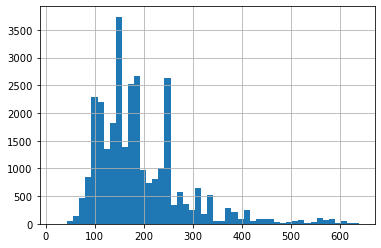

In [73]:
train['enginePower'].hist(bins=50)

In [74]:
test.enginePower.describe()

count    34686.000000
mean       188.194142
std         89.087035
min         30.000000
25%        125.000000
50%        169.000000
75%        233.000000
max        639.000000
Name: enginePower, dtype: float64

In [75]:
test[test.enginePower <45]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,years_num,age_intervals
771,седан,SKODA,https://auto.ru/cars/used/sale/skoda/100_serie...,белый,NaN,Цена без документов 76000р.\n\nНа автомобиль п...,1.0,42,NaN,бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,74969,1969,"{""code"":""100_SERIES"",""name"":""100 Series"",""ru_n...",100_SERIES,100 1.0 MT (42 л.с.),4,1603229210,RUB,1976,1096411742,"{""id"":""20474326"",""nameplate"":""100"",""displaceme...",SEDAN MECHANICAL 1.0,механическая,EUROPEAN,1 владелец,28 лет и 8 месяцев,Оригинал,задний,Левый,Не требует ремонта,Растаможен,45,117
1777,хэтчбек 3 дв.,SKODA,https://auto.ru/cars/used/sale/skoda/popular/1...,чёрный,NaN,"Авто после длительного простоя, под восстановл...",1.1,30,NaN,бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,14000,1934,"{""code"":""POPULAR"",""name"":""Popular"",""ru_name"":""...",POPULAR,1.1 MT (30 л.с.),3,1603232963,RUB,1939,1097046168,"{""id"":""20783514"",""displacement"":1089,""engine_t...",HATCHBACK_3_DOORS MECHANICAL 1.1,механическая,EUROPEAN,3 или более,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен,82,117
16891,седан,MERCEDES,https://auto.ru/cars/used/sale/mercedes/w136/1...,красный,NaN,"Очень редкое авто, было произведено менее 100 ...",1.7,38,NaN,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,1,1936,"{""code"":""W136"",""name"":""W136"",""ru_name"":""в136"",...",W136,1.7 MT (38 л.с.),4,1603245646,RUB,1936,1099428966,"{""id"":""21180018"",""displacement"":1697,""engine_t...",SEDAN MECHANICAL 1.7,механическая,EUROPEAN,1 владелец,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен,85,117
16944,кабриолет,MERCEDES,https://auto.ru/cars/used/sale/mercedes/simple...,белый,NaN,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3,32,NaN,бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,48000,1904,"{""code"":""SIMPLEX"",""name"":""Simplex"",""ru_name"":""...",SIMPLEX,5.3 MT (32 л.с.),0,1603245843,RUB,1904,1093802104,"{""id"":""21743990"",""displacement"":5322,""engine_t...",CABRIO MECHANICAL 5.3,механическая,EUROPEAN,1 владелец,6 лет и 8 месяцев,Оригинал,задний,Правый,Не требует ремонта,Растаможен,117,117
24597,кабриолет,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/type...,синий,NaN,Не участвовала в ДТП.,1.3,40,"{""alloy-wheel-disks"":true,""ptf"":true}",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,50000,1938,"{""code"":""TYPE_1"",""name"":""Type 1"",""ru_name"":""та...",TYPE_1,1.3 MT (40 л.с.),2,1603218189,RUB,1965,1101232282,"{""id"":""20475340"",""displacement"":1300,""engine_t...",CABRIO MECHANICAL 1.3,механическая,EUROPEAN,2 владельца,17 лет и 4 месяца,Оригинал,задний,Левый,Не требует ремонта,Растаможен,56,117
24732,купе,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/type...,чёрный,NaN,Кузов крепкий машина резвом ходу . перед прода...,1.3,44,"{""driver-seat-support"":true,""eco-leather"":true}",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,50000,1938,"{""code"":""TYPE_1"",""name"":""Type 1"",""ru_name"":""та...",TYPE_1,1.3 MT (44 л.с.),2,1603218695,RUB,1973,1100419660,"{""id"":""20475425"",""displacement"":1300,""engine_t...",COUPE MECHANICAL 1.3,механическая,EUROPEAN,2 владельца,16 лет и 9 месяцев,Дубликат,задний,Левый,Не требует ремонта,Растаможен,48,117


У старинных машин-невысокая мощность двигателя. Даже mercedes 5.3л и всего 32 л.с. реально существует:
    https://auto.ru/catalog/cars/mercedes/simplex/21743718/21743897/specifications/21743897__21743990/?from=m

In [76]:
test[test.enginePower > 600]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,years_num,age_intervals
2393,универсал 5 дв.,AUDI,https://auto.ru/cars/used/sale/audi/rs6/110129...,синий,NaN,• Автомобиль проверен по 110 пунктам\n• Автокр...,4.0,605,"{""cruise-control"":true,""asr"":true,""start-stop-...",бензин,https://autoru.naydex.net/ys1kR7800/fbd964zfcB...,65400,2014,"{""code"":""RS6"",""name"":""RS 6"",""ru_name"":""РС6"",""m...",RS6,4.0 AT (605 л.с.) 4WD,5,1603121573,RUB,2016,1101291593,"{""id"":""20711253"",""displacement"":3993,""engine_t...",WAGON_5_DOORS AUTOMATIC 4.0,автоматическая,EUROPEAN,3 или более,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,5,6
2405,седан,AUDI,https://auto.ru/cars/used/sale/audi/s8/1101099...,чёрный,"{""id"":""20755659"",""name"":""Plus"",""available_opti...",Куплена весной 2018 года\nЯ 3й владелец\n\nНи ...,4.0,605,"{""roller-blind-for-rear-window"":true,""esp"":tru...",бензин,https://autoru.naydex.net/ys1kR7800/fbd964zfcB...,40000,2013,"{""code"":""S8"",""name"":""S8"",""ru_name"":""S8"",""morph...",S8,4.0 AT (605 л.с.) 4WD,4,1603121621,RUB,2016,1101099988,"{""id"":""20665131"",""displacement"":3993,""engine_t...",SEDAN AUTOMATIC 4.0,автоматическая,EUROPEAN,3 или более,NaN,Дубликат,полный,Левый,Не требует ремонта,Растаможен,5,6
2544,седан,AUDI,https://auto.ru/cars/used/sale/audi/s8/1101263...,чёрный,"{""id"":""20755659"",""name"":""Plus"",""available_opti...",Внимание! Только для клиентов AVILON Автомобил...,4.0,605,"{""roller-blind-for-rear-window"":true,""tinted-g...",бензин,https://autoru.naydex.net/ys1kR7800/fbd964zfcB...,43208,2013,"{""code"":""S8"",""name"":""S8"",""ru_name"":""S8"",""morph...",S8,4.0 AT (605 л.с.) 4WD,4,1603122190,RUB,2016,1101263303,"{""id"":""20665131"",""displacement"":3993,""engine_t...",SEDAN AUTOMATIC 4.0,автоматическая,EUROPEAN,2 владельца,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,5,6
2869,седан,AUDI,https://auto.ru/cars/used/sale/audi/s8/1101239...,чёрный,NaN,Продается Audi S8 Plus в идеальном внешнем и т...,4.0,605,"{""roller-blind-for-rear-window"":true,""esp"":tru...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,46000,2013,"{""code"":""S8"",""name"":""S8"",""ru_name"":""S8"",""morph...",S8,4.0 AT (605 л.с.) 4WD,4,1603123497,RUB,2016,1101239731,"{""id"":""20665131"",""displacement"":3993,""engine_t...",SEDAN AUTOMATIC 4.0,автоматическая,EUROPEAN,2 владельца,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,5,6
2932,универсал 5 дв.,AUDI,https://auto.ru/cars/used/sale/audi/rs6/110004...,серый,NaN,• Автомобиль проверен по 110 пунктам\n• Автокр...,4.0,605,"{""asr"":true,""airbag-driver"":true,""roller-blind...",бензин,https://autoru.naydex.net/ys1kR7800/fbd964zfcB...,26263,2014,"{""code"":""RS6"",""name"":""RS 6"",""ru_name"":""РС6"",""m...",RS6,4.0 AT (605 л.с.) 4WD,5,1603123762,RUB,2017,1100043230,"{""id"":""20711253"",""displacement"":3993,""engine_t...",WAGON_5_DOORS AUTOMATIC 4.0,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29710,седан,BMW,https://auto.ru/cars/used/sale/bmw/m5/11013239...,чёрный,"{""id"":""21343562"",""name"":""M5 Competition"",""avai...",В продажу поступил легендарный BMW M5 7 поколе...,4.4,625,"{""cruise-control"":true,""asr"":true,""tinted-glas...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,18800,2017,"{""code"":""M5"",""name"":""M5"",""ru_name"":""М5"",""morph...",M5,Competition 4.4 AT (625 л.с.) 4WD,4,1603565489,RUB,2018,1101323960,"{""id"":""21294671"",""name"":""Competition"",""namepla...",SEDAN AUTOMATIC 4.4,автоматическая,EUROPEA

По верхней границе расположились автомобили премиальных марок с двигателями 4.0 и выше.
Выбросов нет

In [77]:
test['log_power'] = np.log(test.enginePower)

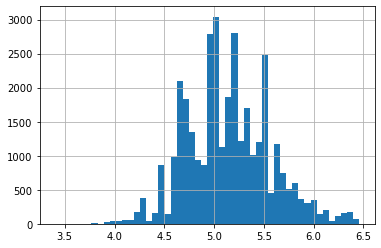

In [78]:
test['log_power'].hist(bins=50)

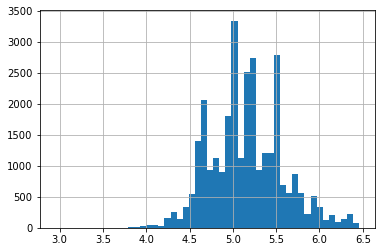

In [79]:
train['log_power'] = np.log(train.enginePower)
train['log_power'].hist(bins=50)

### Признак 'fuelType'

In [80]:
test.fuelType.value_counts()

бензин     28601
дизель      5800
гибрид       223
электро       55
газ            7
Name: fuelType, dtype: int64

In [81]:
train.fuelType.value_counts()

бензин    24131
дизель     5671
ование      284
гибрид      219
 / газ        1
Name: fuelType, dtype: int64

In [82]:
# ование - появилось при парсинге данных, сейчас проверить невозможно, ни одно объявление не открывается
#ошибка 404. Заполним самым частым значением, ориентируясь на похожие объявления
train[train.fuelType =='ование']


,brand,productionDate,bodyType,color,engineDisplacement,enginePower,fuelType,vehicleTransmission,Привод,Руль,Владение,Состояние,Таможня,price,mileage,Владельцы,car_url,model_name,years_num,age_intervals,bodyType1,bodyType_maximum,log_price,log_power
1128,LEXUS,2006,внедорожник 5 дв.,синий,3.5,276,ование,автоматическая,полный,Левый,14 лет и 1 месяц,Не требует ремонта,Растаможен,890000.0,240000,3,https://auto.ru/cars/used/sale/lexus/rx/110296...,RX,15,20,внедорожник 5 дв.,внедорожник 5 дв.,13.698977,5.620401
1416,MITSUBISHI,2001,внедорожник 5 дв.,серебристый,3.5,203,ование,автоматическая,полный,Левый,NaN,Не требует ремонта,Растаможен,350000.0,300000,3,https://auto.ru/cars/used/sale/mitsubishi/mont...,MONTERO,20,20,внедорожник 5 дв.,внедорожник 5 дв.,12.765688,5.313206
2698,TOYOTA,2010,внедорожник 5 дв.,белый,2.7,182,ование,автоматическая,полный,Левый,NaN,Не требует ремонта,Растаможен,1169000.0,276000,1,https://auto.ru/cars/used/sale/toyota/venza/11...,VENZA,11,20,внедорожник 5 дв.,внедорожник 5 дв.,13.971659,5.204007
2788,MITSUBISHI,2006,внедорожник 5 дв.,красный,2.0,136,ование,механическая,полный,Левый,1 год и 9 месяцев,Не требует ремонта,Растаможен,460000.0,220000,3,https://auto.ru/cars/used/sale/mitsubishi/outl...,OUTLANDER,15,20,внедорожник 5 дв.,внедорожник 5 дв.,13.038982,4.912655
2792,MITSUBISHI,2007,универсал 5 дв.,белый,1.6,98,ование,механическая,передний,Левый,NaN,Не требует ремонта,Растаможен,390000.0,225000,2,https://auto.ru/cars/used/sale/mitsubishi/lanc...,LANCER,14,20,универсал 5 дв.,универсал 5 дв.,12.873902,4.584967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127862,INFINITI,2012,внедорожник 5 дв.,чёрный,5.6,405,ование,автоматическая,полный,Левый,NaN,Не требует ремонта,Растаможен,1500000.0,207000,3,https://auto.ru/cars/used/sale/infiniti/qx56/1...,QX56,9,13,внедорожник 5 дв.,внедорожник 5 дв.,14.220976,6.003887
132988,VOLKSWAGEN,2007,минивэн,чёрный,2.0,115,ование,механическая,передний,Левый,NaN,Не требует ремонта,Растаможен,819000.0,167000,2,https://auto.ru/cars/used/sale/volkswagen/tran...,TRANSPORTER,14,20,минивэн,минивэн,13.615839,4.744932
135895,MITSUBISHI,2003,внедорожник 5 дв.,синий,3.5,199,ование,автоматическая,полный,Левый,12 месяцев,Не требует ремонта,Растаможен,500000.0,160000,2,https://auto.ru/cars/used/sale/mitsubishi/mont...,MONTERO_SPORT,18,20,внедорожник 5 дв.,внедорожник 5 дв.,13.122363,5.293305
204465,NISSAN,2008,седан,чёрный,2.5,182,ование,вариатор,передний,Левый,NaN,Не требует ремонта,Растаможен,525000.0,190000,3,https://auto.ru/cars/used/sale/nissan/teana/11...,TEANA,13,20,седан,седан,13.171154,5.204007


In [83]:
train['fuelType'] = train['fuelType'].apply(lambda x: 'бензин' if x == 'ование' else x)
train['fuelType'] = train['fuelType'].apply(lambda x: 'газ' if x == ' / газ' else x)

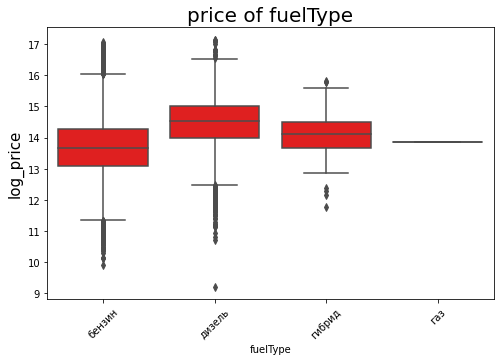

In [84]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='fuelType', 
                  data=train, color='red')
g1.set_title("price of fuelType", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)


plt.show()

Автомобили на дизеле дороже автомобилей на бензине. На газе автомобили самые дешевые и самые редкие

### Признак 'vehicleTransmission'

In [85]:
test.vehicleTransmission.value_counts()

автоматическая      19596
механическая         7209
вариатор             3999
роботизированная     3882
Name: vehicleTransmission, dtype: int64

In [86]:
train.vehicleTransmission.value_counts()

автоматическая      17521
механическая         5214
роботизированная     3696
вариатор             3491
полный                251
передний               97
задний                 29
17 325 ₽ / год          3
13 715 ₽ / год          1
980 ₽ / год             1
1 176 ₽ / год           1
1 188 ₽ / год           1
Name: vehicleTransmission, dtype: int64

Заменим странные значения, которые попали во время пасрсинга на наиболее часто встречающееся значение ' автоматическая'

In [87]:
train['vehicleTransmission'] = train['vehicleTransmission'].apply(lambda x: 'автоматическая' if x == 'полный' else x)
train['vehicleTransmission'] = train['vehicleTransmission'].apply(lambda x: 'автоматическая' if x == 'передний' else x)
train['vehicleTransmission'] = train['vehicleTransmission'].apply(lambda x: 'автоматическая' if x == 'задний' else x)




In [88]:
train[train['vehicleTransmission'].str.contains( 'год')]

,brand,productionDate,bodyType,color,engineDisplacement,enginePower,fuelType,vehicleTransmission,Привод,Руль,Владение,Состояние,Таможня,price,mileage,Владельцы,car_url,model_name,years_num,age_intervals,bodyType1,bodyType_maximum,log_price,log_power
179,TOYOTA,2017,хэтчбек 5 дв.,серый,1.8,98,гибрид,1 176 ₽ / год,автоматическая,передний,NaN,Правый,Растаможен,2150000.0,22000,Н,https://auto.ru/cars/used/sale/toyota/prius/11...,PRIUS,4,6,хэтчбек 5 дв.,хэтчбек 5 дв.,14.580978,4.584967
7816,AUDI,2011,внедорожник 5 дв.,чёрный,2.0,211,гибрид,13 715 ₽ / год,автоматическая,полный,1 год и 3 месяца,Левый,Растаможен,1120000.0,219000,Н,https://auto.ru/cars/used/sale/audi/q5/1103657...,Q5,10,13,внедорожник 5 дв.,внедорожник 5 дв.,13.928839,5.351858
8937,BMW,2018,купе,серый,1.5,231,гибрид,17 325 ₽ / год,автоматическая,полный,NaN,Левый,Растаможен,7250000.0,17979,Н,https://auto.ru/cars/used/sale/bmw/i8/11018049...,I8,3,3,купе,купе,15.796512,5.442418
10537,BMW,2018,купе,белый,1.5,231,гибрид,17 325 ₽ / год,автоматическая,полный,NaN,Левый,Растаможен,7310000.0,18015,Н,https://auto.ru/cars/used/sale/bmw/i8/11029850...,I8,3,3,купе,купе,15.804754,5.442418
16539,TOYOTA,2013,хэтчбек 5 дв.,белый,1.8,99,гибрид,1 188 ₽ / год,автоматическая,передний,NaN,Левый,Растаможен,1288000.0,200000,Н,https://auto.ru/cars/used/sale/toyota/prius/10...,PRIUS,8,13,хэтчбек 5 дв.,хэтчбек 5 дв.,14.068601,4.595120
29051,TOYOTA,2019,хэтчбек 5 дв.,белый,1.8,98,гибрид,980 ₽ / год,автоматическая,передний,NaN,Левый,Растаможен,2100000.0,42000,Н,https://auto.ru/cars/used/sale/toyota/prius/11...,PRIUS,2,3,хэтчбек 5 дв.,хэтчбек 5 дв.,14.557448,4.584967
213020,BMW,2018,купе,белый,1.5,231,гибрид,17 325 ₽ / год,автоматическая,полный,NaN,Левый,Растаможен,7200000.0,18015,Н,https://auto.ru/cars/used/sale/bmw/i8/11029850...,I8,3,3,купе,купе,15.789592,5.442418


Можно перенести значения в правильные столбцы, но так как ошибочных данных всего 14 строк 
чтобы сэкономить время удалим их:

In [89]:
data_mistake = train[train['vehicleTransmission'].str.contains( 'год')].index
#data.drop(data[data['vehicleTransmission'].str.contains( 'год')], axis =0)
data_mistake

Int64Index([179, 7816, 8937, 10537, 16539, 29051, 213020], dtype='int64')

In [90]:
list1 =list(data_mistake)
list1

[179, 7816, 8937, 10537, 16539, 29051, 213020]

In [91]:
train =train.drop(list1)

In [92]:
train.vehicleTransmission.value_counts()

автоматическая      17898
механическая         5214
роботизированная     3696
вариатор             3491
Name: vehicleTransmission, dtype: int64

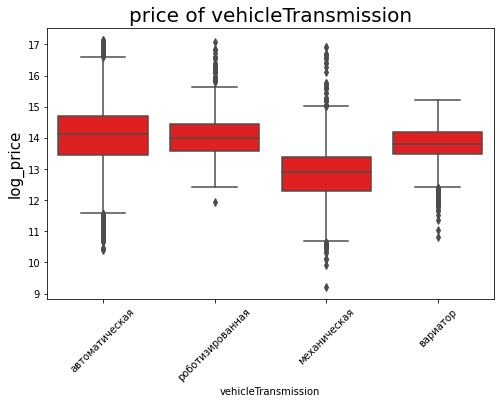

In [93]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='vehicleTransmission', 
                  data=train, color='red')
g1.set_title("price of vehicleTransmission", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

Самые дорогие машины с автоматической коробкой передач, самые дешевые с механической

### Признак 'Привод'

In [94]:
test['Привод'].value_counts()

передний    15565
полный      15020
задний       4101
Name: Привод, dtype: int64

In [95]:
train['Привод'].value_counts()

полный      13878
передний    12910
задний       3134
Левый         370
Правый          7
Name: Привод, dtype: int64

In [96]:
# Заменим в трейне неправильно спарсенные значения на самые часто встречающиеся
train['Привод'] = train['Привод'].apply(lambda x: 'полный' if x == 'Левый' else x)
train['Привод'] = train['Привод'].apply(lambda x: 'полный' if x == 'Правый' else x)

In [97]:
#test[test['Привод'] == 'Левый'].groupby('bodyType')

In [98]:
#test[test['Привод'] == 'Левый']

Пикапы обычно все полноприводные так что можем смело заменить значения 'Левый'и 'Правый' на 'полный'

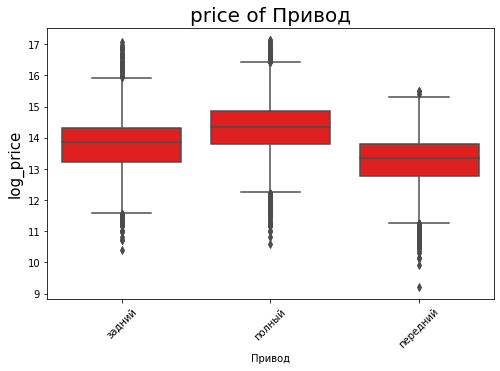

In [99]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='Привод', 
                  data=train, color='red')
g1.set_title("price of Привод", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)


plt.show()

Самые дорогие авто с полным приводом, а самые дешевые с передним. Это легко объясняется отсутствием на переднем
приводе кардана и большого количества деталей, которые есть в полном приводе.

### Признак 'Руль'

In [100]:
test['Руль'].value_counts()

Левый     33287
Правый     1399
Name: Руль, dtype: int64

In [101]:
train['Руль'].value_counts()

Левый                 28741
Правый                 1181
Не требует ремонта      377
Name: Руль, dtype: int64

In [102]:
# Заменим неправильные значния на наиболее часто встречающиеся
train['Руль'] = train['Руль'].apply(lambda x: 'Левый' if x == 'Не требует ремонта' else x)

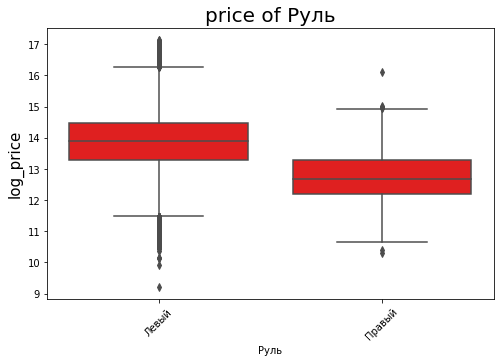

In [103]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='Руль', 
                  data=train, color='red')
g1.set_title("price of Руль", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

Автомобилей с левым рулем подавляющее большинство и стоят они дороже праворулек

### Признак 'Владение'

In [104]:
test['Владение'].isna().sum()

22691

In [105]:
test['Владение'].value_counts()

1 год и 10 месяцев     209
2 года                 197
1 год                  194
1 год и 1 месяц        193
1 год и 2 месяца       187
                      ... 
26 лет и 5 месяцев       1
18 лет и 10 месяцев      1
21 год и 9 месяцев       1
21 год и 11 месяцев      1
24 года и 2 месяца       1
Name: Владение, Length: 275, dtype: int64

In [106]:
train['Владение'].isna().sum()

20139

In [107]:
train['Владение'].value_counts()

6 месяцев               201
7 месяцев               193
8 месяцев               187
5 месяцев               183
9 месяцев               180
                       ... 
43 года и 6 месяцев       1
18 лет и 10 месяцев       1
24 года и 11 месяцев      1
22 года и 12 месяцев      1
34 года и 10 месяцев      1
Name: Владение, Length: 271, dtype: int64

In [108]:
train['Владение'].describe()

count         10160
unique          271
top       6 месяцев
freq            201
Name: Владение, dtype: object

 В признаке 'Владение' очень много пропущенных значений, больше 70%, так что отложим его и пока не будем использовать для построения модели
Но интересно , что самое частое значение   6  месяцев, а 90% значеий находятся от 6 до 12 месяцев года до 2х

import datetime
timestamp = 1603226284
value = datetime.datetime.fromtimestamp(timestamp)
print(value.strftime('%Y-%m-%d '))

### Признак 'mileage'

In [109]:
test['mileage'].value_counts()

200000    436
150000    382
300000    381
180000    347
250000    346
         ... 
109473      1
299910      1
101253      1
23423       1
73732       1
Name: mileage, Length: 11268, dtype: int64

In [110]:
train['mileage'].value_counts()

200000    312
250000    288
150000    263
300000    246
170000    219
         ... 
176300      1
69800       1
125095      1
272543      1
167938      1
Name: mileage, Length: 11248, dtype: int64

In [111]:
train.mileage.describe()

count      30299.000000
mean      152989.750058
std        98784.875005
min            1.000000
25%        81000.000000
50%       140000.000000
75%       204000.000000
max      1000000.000000
Name: mileage, dtype: float64

In [112]:
#  Примерный километраж в год
train.groupby('years_num').mileage.mean().head(10)

years_num
0       789.010101
1     12792.374674
2     34582.818985
3     60205.177159
4     81915.739946
5     96759.306824
6    110192.026801
7    123448.976786
8    135307.278040
9    145685.037632
Name: mileage, dtype: float64

В среднем за первый год машина проходит до 10 000 км, а после по 20000

In [113]:
train[train.mileage == 1]

,brand,productionDate,bodyType,color,engineDisplacement,enginePower,fuelType,vehicleTransmission,Привод,Руль,Владение,Состояние,Таможня,price,mileage,Владельцы,car_url,model_name,years_num,age_intervals,bodyType1,bodyType_maximum,log_price,log_power
3578,MERCEDES,2020,минивэн,чёрный,2.1,190,дизель,автоматическая,полный,Левый,6 месяцев,Не требует ремонта,Растаможен,19925000.0,1,1,https://auto.ru/cars/used/sale/mercedes/v_klas...,V_KLASSE,1,3,минивэн,минивэн,16.807486,5.247024
5214,LEXUS,2021,внедорожник 5 дв.,серый,2.0,238,бензин,автоматическая,полный,Левый,1 месяц,Не требует ремонта,Растаможен,3990000.0,1,1,https://auto.ru/cars/used/sale/lexus/nx/110341...,NX,0,3,внедорожник 5 дв.,внедорожник 5 дв.,15.199302,5.472271
5592,MITSUBISHI,2018,внедорожник 5 дв.,белый,3.0,174,бензин,автоматическая,полный,Левый,2 месяца,Не требует ремонта,Растаможен,3250000.0,1,1,https://auto.ru/cars/used/sale/mitsubishi/paje...,PAJERO,3,3,внедорожник 5 дв.,внедорожник 5 дв.,14.994166,5.159055
9432,MERCEDES,2021,минивэн,чёрный,2.1,190,дизель,автоматическая,полный,Левый,1 месяц,Не требует ремонта,Растаможен,8390000.0,1,1,https://auto.ru/cars/used/sale/mercedes/v_klas...,V_KLASSE,0,3,минивэн,минивэн,15.942551,5.247024
15621,MERCEDES,2021,внедорожник 5 дв.,чёрный,2.0,245,дизель,автоматическая,полный,Левый,NaN,Не требует ремонта,Растаможен,5350000.0,1,1,https://auto.ru/cars/used/sale/mercedes/glc_co...,GLC_COUPE,0,3,внедорожник 5 дв.,внедорожник 5 дв.,15.492607,5.501258
45098,MERCEDES,2021,минивэн,чёрный,2.1,190,дизель,автоматическая,полный,Левый,2 месяца,Не требует ремонта,Растаможен,14950000.0,1,1,https://auto.ru/cars/used/sale/mercedes/v_klas...,V_KLASSE,0,3,минивэн,минивэн,16.520222,5.247024
62717,MITSUBISHI,2018,внедорожник 5 дв.,белый,3.0,174,бензин,автоматическая,полный,Левый,2 месяца,Не требует ремонта,Растаможен,3198000.0,1,1,https://auto.ru/cars/used/sale/mitsubishi/paje...,PAJERO,3,3,внедорожник 5 дв.,внедорожник 5 дв.,14.978036,5.159055
85395,MERCEDES,2021,минивэн,чёрный,2.0,239,дизель,автоматическая,полный,Левый,4 месяца,Не требует ремонта,Растаможен,17850000.0,1,1,https://auto.ru/cars/used/sale/mercedes/v_klas...,V_KLASSE,0,3,минивэн,минивэн,16.697514,5.476464
89329,MERCEDES,2020,минивэн,чёрный,2.1,190,дизель,автоматическая,полный,Левый,6 месяцев,Не требует ремонта,Растаможен,24200000.0,1,1,https://auto.ru/cars/used/sale/mercedes/v_klas...,V_KLASSE,1,3,минивэн,минивэн,17.001863,5.247024
93431,MERCEDES,2021,минивэн,чёрный,2.1,190,дизель,автоматическая,полный,Левый,NaN,Не требует ремонта,Растаможен,19925000.0,1,1,https://auto.ru/cars/used/sale/mercedes/v_klas...,V_KLASSE,0,3,минивэн,минивэн,16.807486,5.247024


Минимальный пробег 1 км неправдоподобно мало для б/у авто. За год автомобиль проходит минимум 1000 км, заменим значения с пробегами меньше 100 км

In [114]:
test[test.mileage == 1]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,years_num,age_intervals,log_power
5857,внедорожник 5 дв.,HONDA,https://auto.ru/cars/used/sale/honda/cr_v/1100...,белый,"{""id"":""21010870"",""name"":""Executive"",""available...",Комплектация «Executive»:\n• Антиблокировочная...,2.0,150,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,1,2016,"{""code"":""CR_V"",""name"":""CR-V"",""ru_name"":""CR-V"",...",CR_V,2.0 CVT (150 л.с.) 4WD,5,1603255952,RUB,2019,1100623326,"{""id"":""21056663"",""displacement"":1997,""engine_t...",ALLROAD_5_DOORS VARIATOR 2.0,вариатор,JAPANESE,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,2,3,5.010635
15472,минивэн,MERCEDES,https://auto.ru/cars/used/sale/mercedes/v_klas...,синий,NaN,Все машины Вы можете посмотреть нажав над объя...,2.1,163,NaN,дизель,https://avatars.mds.yandex.net/get-autoru-vos/...,1,2014,"{""code"":""V_KLASSE"",""name"":""V-Класс"",""ru_name"":...",V_KLASSE,220 d компактный 2.1d AT (163 л.с.) 4WD,5,1603240230,RUB,2019,1096713586,"{""id"":""21363590"",""name"":""220"",""nameplate"":""220...",MINIVAN AUTOMATIC 2.1,автоматическая,EUROPEAN,1 владелец,9 месяцев,Оригинал,полный,Левый,Не требует ремонта,Растаможен,2,3,5.093750
15640,минивэн,MERCEDES,https://auto.ru/cars/used/sale/mercedes/v_klas...,чёрный,"{""id"":""21721636"",""name"":""V250 d Collection 4MA...",В данной конфигурации мы предусмотрели для Вас...,2.1,190,"{""asr"":true,""tinted-glass"":true,""esp"":true,""us...",дизель,https://avatars.mds.yandex.net/get-autoru-vos/...,1,2014,"{""code"":""V_KLASSE"",""name"":""V-Класс"",""ru_name"":...",V_KLASSE,250 d экстра длинный 2.1d AT (190 л.с.) 4WD,5,1603240898,RUB,2020,1101241249,"{""id"":""21363597"",""name"":""250"",""nameplate"":""250...",MINIVAN AUTOMATIC 2.1,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1,3,5.247024
15939,минивэн,MERCEDES,https://auto.ru/cars/used/sale/mercedes/v_klas...,чёрный,"{""id"":""21533563"",""name"":""V250 d AVG Edition 4M...",В данной конфигурации мы предусмотрели для Вас...,2.1,190,"{""tinted-glass"":true,""esp"":true,""usb"":true,""mu...",дизель,https://avatars.mds.yandex.net/get-autoru-vos/...,1,2014,"{""code"":""V_KLASSE"",""name"":""V-Класс"",""ru_name"":...",V_KLASSE,250 d экстра длинный 2.1d AT (190 л.с.) 4WD,5,1603242067,RUB,2020,1099469734,"{""id"":""21363597"",""name"":""250"",""nameplate"":""250...",MINIVAN AUTOMATIC 2.1,автоматическая,EUROPEAN,1 владелец,3 месяца,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1,3,5.247024
16166,внедорожник 5 дв.,MERCEDES,https://auto.ru/cars/used/sale/mercedes/gls_kl...,чёрный,"{""id"":""21601444"",""name"":""GLS 450 4MATIC Sport""...",GLS450 Sport в наличии.\nОт дилера\nНовый. без...,3.0,367,"{""asr"":true,""tinted-glass"":true,""esp"":true,""ad...",бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,1,2019,"{""code"":""GLS_KLASSE"",""name"":""GLS"",""ru_name"":""G...",GLS_KLASSE,450 3.0 AT (367 л.с.) 4WD,5,1603242922,RUB,2020,1101142876,"{""id"":""21601080"",""name"":""450"",""nameplate"":""450...",ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1,3,5.905362
16891,седан,MERCEDES,https://auto.ru/cars/used/sale/mercedes/w136/1...,красный,NaN,"Очень редкое авто, было произведено менее 100 ...",1.7,38,NaN,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,1,1936,"{""code"":""W136"",""name"":""W136"",""ru_name"":""в136"",...",W136,1.7 MT (38 л.с.),4,1603245646,RUB,1936,1099428966,"{""id"":""21180018"",""displacement"":1697,""engine_t...",SEDAN MECHANICAL 1.7,механическая,EUROPEAN,1 владелец,NaN,Оригинал,з

In [115]:
train['mileage'] = train['mileage'].apply(lambda x: 1000 if x <100 else x)
test['mileage'] = test['mileage'].apply(lambda x: 1000 if x <100 else x)

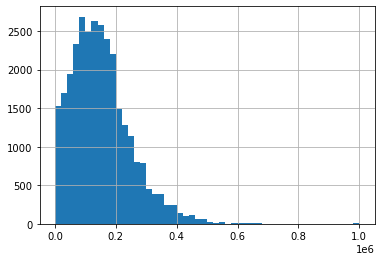

In [116]:
train['mileage'].hist(bins=50)

Большинство б/у машин продается с пробегами до 150 тыс км

### Признак 'Владельцы'

In [117]:
train['Владельцы'].value_counts()

3    12714
1     9239
2     7968
О      349
Д       29
Name: Владельцы, dtype: int64

In [118]:
test['Владельцы'].value_counts()

3 или более    15957
1 владелец      9459
2 владельца     9270
Name: Владельцы, dtype: int64

In [119]:
# Уберем строки с неправильными значениями изз-за парсинга
#train = train.loc[train['Владельцы'] != 'О']
#train = train.loc[train['Владельцы'] != 'Д']

In [120]:
# Обрежем слово владельцы в столбце
test['Владельцы'] = test['Владельцы'].apply(lambda x: x[:1])

In [121]:
# Заменим неизвестные значения на более часто встречающиеся
train['Владельцы'] = train['Владельцы'].apply(lambda x: '3' if x =='Д' else x)
train['Владельцы'] = train['Владельцы'].apply(lambda x: '3' if x =='О' else x)

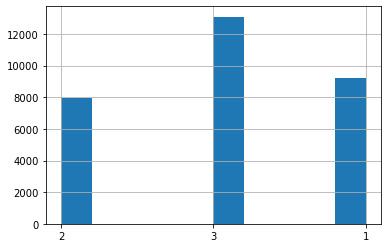

In [122]:
train['Владельцы'].hist()

### Признак 'model_name'

In [123]:
len(test.model_name.value_counts())

544

In [124]:
len(train.model_name.value_counts())

532

In [125]:
test.model_name.value_counts().head(15)

OCTAVIA      1418
5ER          1026
LANCER        855
E_KLASSE      809
PASSAT        782
A6            757
3ER           752
POLO          724
CAMRY         709
X5            675
X_TRAIL       654
A4            626
QASHQAI       609
S_KLASSE      549
OUTLANDER     544
Name: model_name, dtype: int64

In [126]:
train.model_name.value_counts().head(15)

OCTAVIA         1129
CAMRY            837
5ER              791
POLO             656
LANCER           649
3ER              643
E_KLASSE         608
A6               597
PASSAT           578
TIGUAN           570
QASHQAI          517
X5               514
X_TRAIL          508
OUTLANDER        490
LAND_CRUISER     477
Name: model_name, dtype: int64

### Целевая переменная 'price'

In [127]:
train.price.describe()

count    3.029900e+04
mean     1.530331e+06
std      1.738324e+06
min      1.000000e+04
25%      5.500000e+05
50%      1.029000e+06
75%      1.890000e+06
max      2.780000e+07
Name: price, dtype: float64

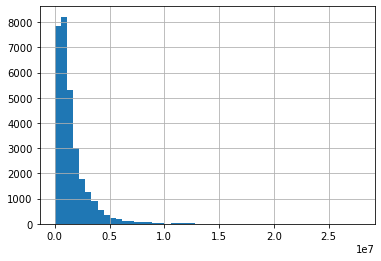

In [128]:
train.price.hist(bins=50)

In [129]:
train[train.price > 20000000]

,brand,productionDate,bodyType,color,engineDisplacement,enginePower,fuelType,vehicleTransmission,Привод,Руль,Владение,Состояние,Таможня,price,mileage,Владельцы,car_url,model_name,years_num,age_intervals,bodyType1,bodyType_maximum,log_price,log_power
1289,MERCEDES,2020,минивэн,чёрный,2.1,190,дизель,автоматическая,полный,Левый,NaN,Не требует ремонта,Растаможен,20330000.0,208,1,https://auto.ru/cars/used/sale/mercedes/v_klas...,V_KLASSE,1,3,минивэн,минивэн,16.827608,5.247024
3582,MERCEDES,2020,внедорожник 5 дв.,чёрный,4.0,585,бензин,автоматическая,полный,Левый,NaN,Не требует ремонта,Растаможен,20998000.0,1899,1,https://auto.ru/cars/used/sale/mercedes/g_klas...,G_KLASSE_AMG,1,3,внедорожник 5 дв.,внедорожник 5 дв.,16.859938,6.371612
4463,MERCEDES,2020,минивэн,чёрный,2.1,190,дизель,автоматическая,полный,Левый,11 месяцев,Не требует ремонта,Растаможен,27800000.0,100,1,https://auto.ru/cars/used/sale/mercedes/v_klas...,V_KLASSE,1,3,минивэн,минивэн,17.140547,5.247024
7287,MERCEDES,2014,родстер,красный,6.2,591,бензин,роботизированная,задний,Левый,NaN,Не требует ремонта,Растаможен,26000000.0,4800,3,https://auto.ru/cars/used/sale/mercedes/sls_am...,SLS_AMG,7,13,родстер,other,17.073607,6.381816
7715,MERCEDES,2020,внедорожник 5 дв.,чёрный,4.0,585,бензин,автоматическая,полный,Левый,NaN,Не требует ремонта,Растаможен,22500000.0,1000,1,https://auto.ru/cars/used/sale/mercedes/g_klas...,G_KLASSE_AMG,1,3,внедорожник 5 дв.,внедорожник 5 дв.,16.929026,6.371612
8598,MERCEDES,2020,минивэн,чёрный,2.1,190,дизель,автоматическая,полный,Левый,7 месяцев,Не требует ремонта,Растаможен,27000000.0,1000,1,https://auto.ru/cars/used/sale/mercedes/v_klas...,V_KLASSE,1,3,минивэн,минивэн,17.111347,5.247024
9042,MERCEDES,2020,внедорожник 5 дв.,чёрный,4.0,585,бензин,автоматическая,полный,Левый,7 месяцев,Не требует ремонта,Растаможен,23000000.0,1000,1,https://auto.ru/cars/used/sale/mercedes/g_klas...,G_KLASSE_AMG,1,3,внедорожник 5 дв.,внедорожник 5 дв.,16.951005,6.371612
15316,MERCEDES,2021,внедорожник 5 дв.,чёрный,4.0,558,бензин,автоматическая,полный,Левый,2 месяца,Не требует ремонта,Растаможен,23000000.0,1000,1,https://auto.ru/cars/used/sale/mercedes/maybac...,MAYBACH_GLS,0,3,внедорожник 5 дв.,внедорожник 5 дв.,16.951005,6.324359
15511,BMW,1960,седан,синий,3.2,140,бензин,механическая,задний,Левый,NaN,Не требует ремонта,Растаможен,22200000.0,1000,1,https://auto.ru/cars/used/sale/bmw/502/1103535...,502,61,117,седан,седан,16.915603,4.941642
16824,MERCEDES,2004,купе,серый,5.4,626,бензин,автоматическая,задний,Левый,NaN,Не требует ремонта,Растаможен,23900000.0,15000,3,https://auto.ru/cars/used/sale/mercedes/slr_kl...,SLR_KLASSE,17,20,купе,купе,16.989389,6.439350


ценовой диапазон ограничивать не стоит - действительно есть очень необычные машины

Видим на графике смещение влево, попробуем логарифмировать ее, чтобы 
получить нормальное распределение

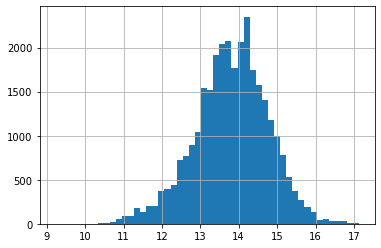

In [130]:
train['log_price'].hist(bins=50)

Видим, что логарифмирование переменной привело к нормальному распределению

### Корреляция признаков:

In [131]:
train.describe()

,productionDate,engineDisplacement,enginePower,price,mileage,years_num,log_price,log_power
count,30299.000000,30299.000000,30299.000000,3.029900e+04,30299.000000,30299.000000,30299.000000,30299.000000
mean,2010.565002,2.408321,191.773458,1.530331e+06,152993.176838,10.434998,13.807891,5.163893
std,7.074448,0.960581,89.991933,1.738324e+06,98779.585368,7.074448,0.960480,0.420908
min,1937.000000,0.600000,19.000000,1.000000e+04,100.000000,0.000000,9.210340,2.944439
25%,2007.000000,1.800000,135.000000,5.500000e+05,81000.000000,5.000000,13.217674,4.905275
50%,2012.000000,2.000000,170.000000,1.029000e+06,140000.000000,9.000000,13.844098,5.135798
75%,2016.000000,3.000000,238.000000,1.890000e+06,204000.000000,14.000000,14.452087,5.472271
max,2021.000000,6.600000,639.000000,2.780000e+07,1000000.000000,84.000000,17.140547,6.459904


In [132]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30299 entries, 1 to 219075
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   brand                30299 non-null  object  
 1   productionDate       30299 non-null  int64   
 2   bodyType             30299 non-null  object  
 3   color                30299 non-null  object  
 4   engineDisplacement   30299 non-null  float32 
 5   enginePower          30299 non-null  int64   
 6   fuelType             30299 non-null  object  
 7   vehicleTransmission  30299 non-null  object  
 8   Привод               30299 non-null  object  
 9   Руль                 30299 non-null  object  
 10  Владение             10160 non-null  object  
 11  Состояние            30299 non-null  object  
 12  Таможня              30299 non-null  object  
 13  price                30299 non-null  float64 
 14  mileage              30299 non-null  int64   
 15  Владельцы         

In [133]:
num_cols =['productionDate','engineDisplacement','enginePower','mileage',
           'years_num','log_price','log_power' ]


In [134]:
correlation = train[num_cols].corr()
correlation

,productionDate,engineDisplacement,enginePower,mileage,years_num,log_price,log_power
productionDate,1.000000,0.021900,0.232314,-0.677226,-1.000000,0.743399,0.279748
engineDisplacement,0.021900,1.000000,0.834571,-0.013438,-0.021900,0.422883,0.812808
enginePower,0.232314,0.834571,1.000000,-0.214356,-0.232314,0.586230,0.955203
mileage,-0.677226,-0.013438,-0.214356,1.000000,0.677226,-0.653091,-0.224761
years_num,-1.000000,-0.021900,-0.232314,0.677226,1.000000,-0.743399,-0.279748
log_price,0.743399,0.422883,0.586230,-0.653091,-0.743399,1.000000,0.639873
log_power,0.279748,0.812808,0.955203,-0.224761,-0.279748,0.639873,1.000000


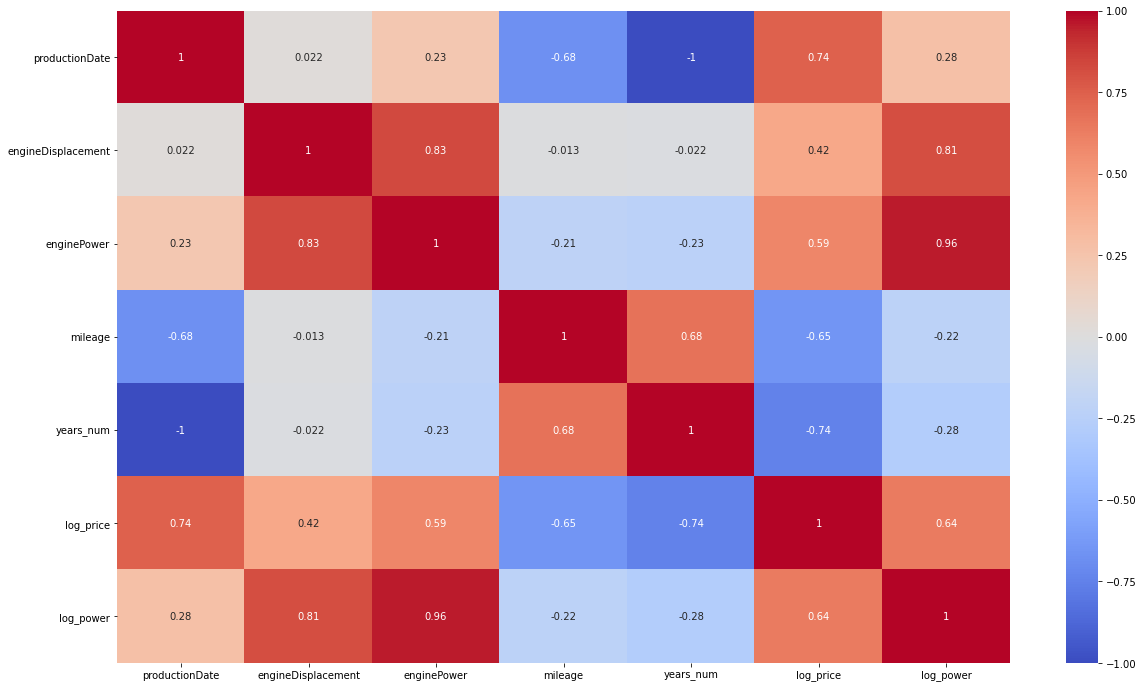

In [135]:
plt.figure(figsize=(20, 12))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

Логарифм цены положительно коррелирует с мощностью двигателя, объемом двигателя и датой выпуска машины.
Отрицательно коррелирует с возрастом машины и пробегом.

### Label Encoding

In [136]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30299 entries, 1 to 219075
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   brand                30299 non-null  object  
 1   productionDate       30299 non-null  int64   
 2   bodyType             30299 non-null  object  
 3   color                30299 non-null  object  
 4   engineDisplacement   30299 non-null  float32 
 5   enginePower          30299 non-null  int64   
 6   fuelType             30299 non-null  object  
 7   vehicleTransmission  30299 non-null  object  
 8   Привод               30299 non-null  object  
 9   Руль                 30299 non-null  object  
 10  Владение             10160 non-null  object  
 11  Состояние            30299 non-null  object  
 12  Таможня              30299 non-null  object  
 13  price                30299 non-null  float64 
 14  mileage              30299 non-null  int64   
 15  Владельцы         

In [137]:
train.columns

Index(['brand', 'productionDate', 'bodyType', 'color', 'engineDisplacement',
       'enginePower', 'fuelType', 'vehicleTransmission', 'Привод', 'Руль',
       'Владение', 'Состояние', 'Таможня', 'price', 'mileage', 'Владельцы',
       'car_url', 'model_name', 'years_num', 'age_intervals', 'bodyType1',
       'bodyType_maximum', 'log_price', 'log_power'],
      dtype='object')

Столбцы 'Владение', 'Состояние', 'Таможня','car_url' ,использовать для моделирования не будем

In [138]:
# Объединим датасеты по схожим признакам:
columns =['brand', 'productionDate', 'bodyType', 'color', 'engineDisplacement',
       'enginePower', 'fuelType', 'vehicleTransmission', 'Привод', 'Руль',
        'mileage', 'Владельцы','model_name',
        'years_num', 'age_intervals', ]
df_train = train[columns]
df_test = test[columns]
y = train['price']

In [139]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

<ipython-input-139-48ac77de6ba5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['sample'] = 1 # помечаем где у нас трейн
<ipython-input-139-48ac77de6ba5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['sample'] = 0 # помечаем где у нас тест


### Генерируем полиномиальные признаки

In [140]:
# Результат применения неудовлетворительный. Рост MAPE при тестировании на 1%

#pf = PolynomialFeatures(2)
#poly_df = pf.fit_transform(data[num_cols])
#poly_df = pd.DataFrame(poly_df)
#poly_df = poly_df.drop(0, axis=1)
#data = pd.concat([data, poly_df],axis=1)
#data

In [141]:
data.sample(4).T

,15075,15730,57292,45760
brand,INFINITI,MERCEDES,MERCEDES,BMW
productionDate,2008,2017,1997,2019
bodyType,внедорожник 5 дв.,седан,внедорожник 5 дв.,седан
color,коричневый,синий,синий,чёрный
engineDisplacement,5,2.9,3.2,3
enginePower,400,340,210,249
fuelType,бензин,дизель,бензин,дизель
vehicleTransmission,автоматическая,автоматическая,автоматическая,автоматическая
Привод,полный,полный,полный,полный
Руль,Левый,Левый,Левый,Левый


### Кодируем категориальные и бинарные признаки:

In [142]:
for column in [ 'brand','bodyType', 'color', 'fuelType','vehicleTransmission', 'Привод', 'Владельцы', 'vehicleTransmission', 'Привод', 'age_intervals','model_name']:
    data[column] = data[column].astype('category').cat.codes
   

In [143]:
bin_cols = [ 'Руль']
label_encoder = LabelEncoder()
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
data.head(10)

,brand,productionDate,bodyType,color,engineDisplacement,enginePower,fuelType,vehicleTransmission,Привод,Руль,mileage,Владельцы,model_name,years_num,age_intervals,sample
0,8,2014,8,13,1.2,105,0,3,1,0,74000,2,343,7,2,0
1,8,2017,8,15,1.6,110,0,2,1,0,60563,0,343,4,1,0
2,8,2014,8,12,1.8,152,0,3,1,0,88000,0,492,7,2,0
3,8,2014,8,6,1.6,110,0,0,1,0,95000,0,343,7,2,0
4,8,2012,8,1,1.8,152,0,0,1,0,58536,0,343,9,2,0
5,8,2012,8,12,2.0,200,0,3,1,0,172000,2,344,9,2,0
6,8,2012,1,9,1.8,152,0,3,2,0,107000,0,583,9,2,0
7,8,2011,8,1,1.6,102,0,2,1,0,226706,2,343,10,2,0
8,8,2019,1,0,1.4,150,0,2,2,0,9706,0,272,2,0,0
9,8,2012,1,1,1.8,152,0,2,2,0,37361,0,583,9,2,0


### Пробуем нормализовать числовые признаки с помощью preprocessing

In [144]:
#num_cols =['productionDate','engineDisplacement','enginePower','mileage',
#           'years_num']
#cat_columns =['brand',  'bodyType', 'color', 
#       'fuelType', 'vehicleTransmission', 'Привод', 'Руль',
#         'Владельцы','model_name',
#        'years_num', 'age_intervals', ]

In [145]:
#data_scal = data.drop(['sample']+cat_columns,axis=1)

In [146]:
#from sklearn import preprocessing
#d = preprocessing.normalize(data_scal)
#scaled_df = pd.DataFrame(d)
#scaled_df.head()    

In [147]:
#scaled_df['sample'] = data['sample']
#data_cat_cols = data[cat_columns]
#data_cat_cols.head()

#scaled_df = pd.concat([scaled_df,data_cat_cols],axis=1)
#scaled_df.head()

 Не будем использовать. В наивной модели дает небольшое улучшение,
но в Catboost и далее ухудшает MAPE более чем на 1%

### Разделяем данные обратно на трейн и тест по признаку sample, и далее делим трейновыый дата сет на обучающую и тестовые выборки:

In [148]:
X = data.query('sample ==1').drop(['sample'], axis=1)
X_sub = data.query('sample ==0').drop(['sample'], axis=1)

In [149]:
X.head()

,brand,productionDate,bodyType,color,engineDisplacement,enginePower,fuelType,vehicleTransmission,Привод,Руль,mileage,Владельцы,model_name,years_num,age_intervals
34686,1,2013,15,15,2.0,184,0,0,0,0,148000,1,31,8,2
34687,1,2013,15,6,1.6,136,0,0,0,0,122233,2,25,8,2
34688,1,2013,15,15,2.0,245,0,0,2,0,129871,2,31,8,2
34689,1,2018,15,12,4.4,600,0,0,2,0,41066,2,302,3,0
34690,1,2019,4,13,1.5,140,0,3,1,0,17380,1,16,2,0


In [150]:
X.isna().sum()

brand                  0
productionDate         0
bodyType               0
color                  0
engineDisplacement     0
enginePower            0
fuelType               0
vehicleTransmission    0
Привод                 0
Руль                   0
mileage                0
Владельцы              0
model_name             0
years_num              0
age_intervals          0
dtype: int64

In [151]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30299 entries, 34686 to 64984
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   brand                30299 non-null  int8   
 1   productionDate       30299 non-null  int64  
 2   bodyType             30299 non-null  int8   
 3   color                30299 non-null  int8   
 4   engineDisplacement   30299 non-null  float32
 5   enginePower          30299 non-null  int64  
 6   fuelType             30299 non-null  int8   
 7   vehicleTransmission  30299 non-null  int8   
 8   Привод               30299 non-null  int8   
 9   Руль                 30299 non-null  int32  
 10  mileage              30299 non-null  int64  
 11  Владельцы            30299 non-null  int8   
 12  model_name           30299 non-null  int16  
 13  years_num            30299 non-null  int64  
 14  age_intervals        30299 non-null  int8   
dtypes: float32(1), int16(1), int32(1

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [153]:
X_train.head()

,brand,productionDate,bodyType,color,engineDisplacement,enginePower,fuelType,vehicleTransmission,Привод,Руль,mileage,Владельцы,model_name,years_num,age_intervals
47027,10,2020,8,1,1.6,90,0,2,1,0,3000,0,371,1,0
47025,10,2011,24,1,1.6,102,0,3,1,0,96402,0,231,10,2
51640,0,2006,15,15,2.0,130,0,1,1,0,171000,2,47,15,3
39880,3,2014,1,15,3.0,238,3,0,2,0,120563,1,409,7,2
38743,9,2004,1,15,4.7,235,0,0,2,0,220000,2,280,17,3


### Model 1: Создадим "наивную" модель


In [154]:


lr = LinearRegression()
lr.fit(X_train, y_train)
predict_test = lr.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mean_absolute_percentage_error(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 76.69%


В данной модели не реализована нормализация признаков, а Линейная регрессия чувствительна к нормализации , поэтому метрика получилась не очень хорошей. С нормализацией признаков модель выдает метрику MAPE=62.66% - это заметное улучшение. Но не будем ее использовать в дальнейшем, так как CatBoost, наоборот не требует нормализации.

### Model 2: Реализуем модель на Catbust.

 Большая часть признаков у нас категориальные. Эта билиотека наиболее сильна в работе с категориальными признаками

In [155]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

predict_test = model.predict(X_test)

In [156]:
print(f"Точность модели по метрике MAPE: {(mean_absolute_percentage_error(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 14.73%


Видим значительное улучшение метрики MAPE: 14.73%

### Логарифмирование целевой переменной и подбор наилучших параметров


Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).

In [157]:
#np.log(y_train) & drop duplicates& big parsing_finall data
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_8_baseline.model')


predict_test = np.exp(model.predict(X_test))
sample_submission = pd.read_csv('sample_submission.csv')



predict_submission = np.exp(model.predict(X_sub))
sample_submission['price'] = predict_submission
VERSION = 11
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)

In [158]:
print(f"Точность модели по метрике MAPE: {(mean_absolute_percentage_error(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.32%


При использовании логарифмирования целевой переменной( логарифмирование делает распределение признака более близким к нормальному) удалось получить улучшение метрики почти на 1.5%

### Поиск наилучших параметров для CatBoostRegressor

In [159]:
cat_features_ids =['brand',  'bodyType', 'color', 
       'fuelType', 'vehicleTransmission', 'Привод', 'Руль',
         'Владельцы','model_name',
        'years_num', 'age_intervals', ]

In [160]:
#np.log(y_train) & drop duplicates& big parsing_finall data

model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_8_baseline.model')


predict_test = np.exp(model.predict(X_test))
sample_submission = pd.read_csv('sample_submission.csv')



predict_submission = np.exp(model.predict(X_sub))
sample_submission['price'] = predict_submission*0.87
VERSION = 20
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)

In [161]:
print(f"Точность модели по метрике MAPE: {(mean_absolute_percentage_error(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.32%


In [162]:

#cbr = CatBoostRegressor(random_state = RANDOM_SEED)

#grid = {'learning_rate': [round(x,3) for x in np.linspace(start = 0.025, stop = 0.4, num = 40)],
#        'depth': [int(x) for x in np.linspace(start = 5, stop = 10, num = 5)],
#        'l2_leaf_reg': [int(x) for x in np.linspace(start = 1, stop = 5, num = 5)]}

#rf_random = RandomizedSearchCV(estimator = cbr, param_distributions = grid, n_iter = 100, cv = 3, verbose=10, random_state=RANDOM_SEED, n_jobs = -1)
#rf_random.fit(X_train, np.log(y_train))
#rf_random.best_params_
#{'learning_rate': 0.092, 'l2_leaf_reg': 3, 'depth': 8}

In [163]:
#{'learning_rate': 0.092, 'l2_leaf_reg': 3, 'depth': 8}

In [164]:
#np.log(y_train) & drop duplicates& big parsing_finall data
model = CatBoostRegressor(iterations = 3000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         learning_rate =  0.092, l2_leaf_reg= 3, depth=8)
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_8_baseline.model')


predict_test = np.exp(model.predict(X_test))
sample_submission = pd.read_csv('sample_submission.csv')



predict_submission = np.exp(model.predict(X_sub))
sample_submission['price'] = predict_submission*0.87
VERSION = 15
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
print(f"Точность модели по метрике MAPE: {(mean_absolute_percentage_error(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.28%


###  Model 3 : GradientBoostingRegressor

Построим модель основанную на градиентном бустинге

In [165]:
gb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=1000)
gb.fit(X_train, np.log(y_train))

GradientBoostingRegressor(learning_rate=0.03, max_depth=10, n_estimators=1000)

In [166]:
predict_test = np.exp(gb.predict(X_test))
predict_submission = np.exp(gb.predict(X_sub))

In [167]:
print(f"Точность модели по метрике MAPE: {(mean_absolute_percentage_error(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.48%


Градиентный бустинг дал неплохое значение метрик, но все-таки он уступает CatBoost

### Model 4 : RandomForestRegressor

Построим модель с помощью RandomForestRegressor

In [168]:
rfr = RandomForestRegressor(n_estimators=1000, max_depth = 15, max_features = 'log2', random_state = 42, oob_score=True,)
rfr.fit(X_train, np.log(y_train))

RandomForestRegressor(max_depth=15, max_features='log2', n_estimators=1000,
                      oob_score=True, random_state=42)

In [169]:
predict_test = np.exp(rfr.predict(X_test))
predict_submission = np.exp(rfr.predict(X_sub))

In [170]:
print(f"Точность модели по метрике MAPE: {(mean_absolute_percentage_error(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.99%


Попробуем улучшить модель, подобрав гиперпараметры с помощью RandomizedSearchCV

In [171]:
#random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 4)],
#               'max_features': ['auto', 'sqrt'],
#               'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
#               'min_samples_split': [2, 5, 10],
#               'min_samples_leaf': [1, 2, 4],
#               'bootstrap': [True, False]}

#rfr = RandomForestRegressor(random_state = RANDOM_SEED)
#rf_random = RandomizedSearchCV(estimator = rfr, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10, random_state=RANDOM_SEED, n_jobs = -1)
#rf_random.fit(X_train, np.log(y_train))
#rf_random.best_params_




In [172]:
best_rfr = RandomForestRegressor(random_state=RANDOM_SEED
                      , n_estimators=300
                      , min_samples_split=10
                      , min_samples_leaf=1
                      , max_features='sqrt'
                      , max_depth=None
                      , bootstrap=False)
best_rfr.fit(X_train, np.log(y_train))
predict_test = np.exp(best_rfr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mean_absolute_percentage_error(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.81%


Подбор гиперпараметров позволил улучшить метрику на 0.18%

Попробуем применить бэггинг к алгоритмам RandomForest и GradientBoosting. Из эксперимента видно, что метрика только ухудшилась. Думаю так как RandomForest и так построен на бэггинге,это только увеличило ошибку. эксперимент не удался.
Поэтому 5 и 6 модели оставляем только как историю опытов

### Model 5: BaggingRegressor c RandomForest(rfr)

In [173]:
bagg_rfr = BaggingRegressor(best_rfr, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)

bagg_rfr.fit(X_train, np.log(y_train))
predict_test = np.exp(bagg_rfr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mean_absolute_percentage_error(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 14.38%


### Model 6: BaggingRegressor c градиентным бустингом

In [174]:
bagg_gbr = BaggingRegressor(gb, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
bagg_gbr.fit(X_train, np.log(y_train))
predict_test = np.exp(bagg_gbr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mean_absolute_percentage_error(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.55%


### Model 7:  Стеккинг

In [183]:
estimators=[('gb', GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=1000))
            ,('ct',CatBoostRegressor(iterations = 5000
                                                                     ,random_seed = RANDOM_SEED
                                                                     ,eval_metric='MAPE'
                                                                     ,custom_metric=['R2', 'MAE']
                                                                     ,silent=True
                                                                     ,learning_rate=0.13
                                                                     ,depth=12
                                                                     ,l2_leaf_reg=8
                                                                     ,random_strength=0.3))]

st_ensemble = StackingRegressor(estimators=estimators
                                ,final_estimator = LinearRegression())

    
    
st_ensemble.fit(X_train, np.log(y_train))

predict_ensemble = np.exp(st_ensemble.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mean_absolute_percentage_error(y_test, predict_ensemble))*100:0.2f}%")              

Точность модели по метрике MAPE: 13.35%


Стекинг  дал нам точность MAPE: 13.35% , показатель лучше чем отдельно у GradientBoostingRegressor, но хуже чем CatBoostRegressor, возможно стоит выбрать другие модели для стекинга. Замечание,  стекинг считается очень медленно.

### Улучшим Model 2 за счет коэффициента зависимости цены авто от времени:

Обратим внимание на столбец 'parsing_unixtime' в нашем тестовом датафрейме и вытащим время парсинга данных:

In [176]:
test.time = pd.to_datetime(test['parsing_unixtime'],unit='s')

<ipython-input-176-575a77b6a514>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  test.time = pd.to_datetime(test['parsing_unixtime'],unit='s')


In [177]:
test.time.value_counts()

2020-10-19 17:12:07    1
2020-10-21 12:36:49    1
2020-10-21 05:09:36    1
2020-10-26 03:40:13    1
2020-10-21 07:37:02    1
                      ..
2020-10-20 18:59:39    1
2020-10-19 17:20:40    1
2020-10-19 13:40:51    1
2020-10-24 19:31:16    1
2020-10-21 10:44:35    1
Name: parsing_unixtime, Length: 34686, dtype: int64

In [178]:
test.time.describe()

count                   34686
unique                  34686
top       2020-10-19 17:12:07
freq                        1
first     2020-10-19 11:35:06
last      2020-10-26 11:04:24
Name: parsing_unixtime, dtype: object

## Данные спарсены в период с 19 по 26 октября 2020года. Погуглим:
    https://www.drive2.ru/b/587444049904954727/
Цена на самые популярные машины выросла на 10-20%. Опять же, среднестатистический солярис 12 месяцев назад стоил 554 тр, сейчас 624 тр (+13%), Сид: 701 тр…779 тр (+11%), Камри: 1197 тр…1407 тр (+17%), БМВ 5: 1460 тр… 1736 тр (+19%!). Еще раз: среднестатистические модели! В целом, средняя цена на БУ авто в России выросла с 535 тр до 670 тр (25%).

Возьмем среднюю температуру по больнице 13%
    100% - 13% = 87%
Введем понижающий коэффициент к нашей модели равный 0.87
    

In [179]:
#np.log(y_train) & drop duplicates& big parsing_finall data& coef 0.87&model_name
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

#model.save_model('catboost_single_model_13_baseline.model')


predict_test = np.exp(model.predict(X_test))
sample_submission = pd.read_csv('sample_submission.csv')



predict_submission = np.exp(model.predict(X_sub))
sample_submission['price'] = predict_submission*0.87
VERSION = 16
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)

In [180]:
print(f"Точность модели по метрике MAPE: {(mean_absolute_percentage_error(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.32%


### Выводы:

1. В ходе проекта мне удалось реализовать парсинг достаточно большого объема данных сайта auto.ru. Порядка 219 000 позиций. К сожалению после очистки данных и удаления дубликатов объявлений(их оказалось чень много) у меня остался достатчно небольшой набор данных для трейна порядка 30 000 строк. Думаю, при наличии большего количества времени и ресурсов я получил бы больше данных для обучения моделей, хотя бы в 3-4 раза больше чем тестовый датасет, и это бы положительно сказалось на качестве моделей обучения. Можно было бы еще улучшить метрику.

2. При парсинге данных изначально не заложил такие признаки как 'ПТС','numberOfDoors', 'vendor'(потом было поздно). Большее количество признаков так же бы улучшило предсказания.

3. При моделировании удалось понять, что специализированные билиотеки при подборе гиперпараметров дают намного лучшие результаты.

4. Результат в большей степени зависит от качества данных. Следует больше времени уделять сбору, очистке данных, feature engineering. Это, вместе с выбором правильной модели, в конечном итоге даст больший результат чем настройка гиперпараметров. С помошью улучшения качества данных можно получить улучшение предсказаний моделирования на порядок, в то время как точная подстройка даст проценты или же доли процентов улучшения.

5. Цель проекта достигнута. Построена модель, способная предсказывать стоимость автомобилей с ошибкой MAPE = 13.28% 